In [1]:
from helper_funcs_kdd import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
import io
from tqdm import tqdm
import time
import jinja2
from scipy.stats import norm
import glob
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
dpi = 200
font_size = 10

In [2]:
# read in all excel files from the Housing Dataset folder
# and merge them into a single dataframe using pa

# Path to the directory containing the .xlsx files
file_path = "../data/Housing_Dataset/*.xlsx"

# Use glob to get all file names
excel_files = glob.glob(file_path)
print(excel_files)
# Initialize an empty list to store DataFrames
dataframes = []

# Loop through the list of files and read each into a DataFrame
for file in excel_files:
    df = pd.read_excel(file)  # Read the Excel file
    df.columns = df.columns.str.lower()
    dataframes.append(df)     # Append the DataFrame to the list

# Concatenate all DataFrames into a single one
housing_df = pd.concat(dataframes, ignore_index=True)

#  select shipmonth, sqft, price, number of bedrooms, foundation, footing, pier secured
housing_df = housing_df[['shipmonth', 
                         'sqft', 'price', 'bedrooms', 'foundation', 'secured',
                         'jprice', 'jsqft', 'jbedroom', 'jfoundation', 'jsecured']]
# subset to all j columns being R 
housing_df = housing_df[(housing_df['jprice'] == 'R') & 
                        (housing_df['jsqft'] == 'R') & 
                        (housing_df['jbedroom'] == 'R') & 
                        (housing_df['jfoundation'] == 'R') & 
                        (housing_df['jsecured'] == 'R')]
# drop the j columns
housing_df = housing_df.drop(columns=['jprice', 'jsqft', 'jbedroom', 'jfoundation', 'jsecured'])
# remove all rows that have 9 in any column - stands for not applicable value
housing_df = housing_df[~housing_df.apply(lambda row: row.isin([9]).any(), axis=1)]
# turn shipmonth to datetime object
housing_df['shipmonth'] = pd.to_datetime(housing_df['shipmonth'], format='%Y%m')
print(housing_df.head())
#print unique shipmonth
print(housing_df['shipmonth'].unique())

['../data/Housing_Dataset/PUF2020.xlsx', '../data/Housing_Dataset/PUF2017.xlsx', '../data/Housing_Dataset/PUF2018.xlsx', '../data/Housing_Dataset/PUF2019.xlsx']
    shipmonth  sqft  price  bedrooms  foundation  secured
4  2020-01-01   500  87000         1           3        1
19 2020-01-01  1200  63000         3           3        1
20 2020-01-01   840  44500         1           3        1
31 2020-01-01   840  47000         1           3        1
32 2020-01-01   940  67000         1           3        1
<DatetimeArray>
['2020-01-01 00:00:00', '2020-02-01 00:00:00', '2020-03-01 00:00:00',
 '2020-04-01 00:00:00', '2020-05-01 00:00:00', '2020-06-01 00:00:00',
 '2020-07-01 00:00:00', '2020-08-01 00:00:00', '2020-09-01 00:00:00',
 '2020-10-01 00:00:00', '2020-11-01 00:00:00', '2020-12-01 00:00:00',
 '2017-01-01 00:00:00', '2017-02-01 00:00:00', '2017-03-01 00:00:00',
 '2017-04-01 00:00:00', '2017-05-01 00:00:00', '2017-06-01 00:00:00',
 '2017-07-01 00:00:00', '2017-08-01 00:00:00', '2017-09

<Figure size 1280x960 with 0 Axes>

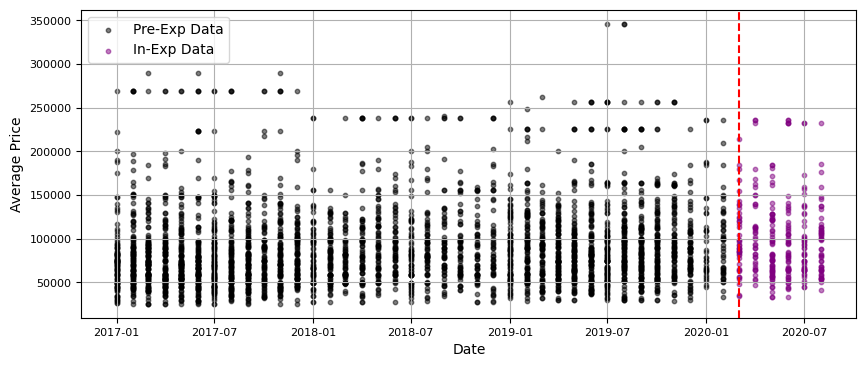

In [3]:
plt.figure(dpi=dpi)
plt.figure(figsize=(10, 4))
# plot average house price over time
# group by shipmonth and calculate the average price
# convert string 2020-03-01 to datetime object
critical_juncture = pd.to_datetime('2020-03-01', format='%Y-%m-%d')

price_over_time = housing_df.groupby('shipmonth')['price'].mean()
# plot the average price over time
# first convert all categorical columns to dummies
df = pd.get_dummies(housing_df, columns = ['foundation', 'secured'], drop_first=True)
# split the data into training and testing
train = df[df['shipmonth'] < critical_juncture]
test = df[(df['shipmonth'] >= critical_juncture) & (df['shipmonth'] < '2020-09-01')]
#plt.plot(price_over_time, ls = '--' , color = 'purple', label='Average Price')
# overlay a scatterplot of individual house prices at each timepoint
plt.scatter(train['shipmonth'], train['price'], color='black', alpha=0.5, s=10, label='Pre-Exp Data')
plt.scatter(test['shipmonth'], test['price'], color='purple', alpha=0.5, s=10, label='In-Exp Data')
plt.axvline(x=critical_juncture, color='red', ls='--')
ax = plt.gca()
# Set font size for the x and y axis ticks
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
plt.legend(fontsize = font_size)
plt.xlabel('Date', fontsize = font_size)
plt.ylabel('Average Price', fontsize = font_size)
plt.grid(True)
plt.savefig('kdd_plots/housing_data.png', dpi=dpi)
plt.show()

In [4]:
# fit a machine learning model predicting the price based on all columns including date
# split date to year and time for both train and test
train['year'] = train['shipmonth'].dt.year
train['month'] = train['shipmonth'].dt.month
test['year'] = test['shipmonth'].dt.year
test['month'] = test['shipmonth'].dt.month
train_dates = np.array(train['shipmonth'])
test_dates = np.array(test['shipmonth'])
# drop the shipmonth column
train = train.drop(columns=['shipmonth'])
test = test.drop(columns=['shipmonth'])
# apply cyclical encoding to month
train['month_sin'] = np.sin(2*np.pi*train['month']/12)
train['month_cos'] = np.cos(2*np.pi*train['month']/12)
test['month_sin'] = np.sin(2*np.pi*test['month']/12)
test['month_cos'] = np.cos(2*np.pi*test['month']/12)
# drop the month column
train = train.drop(columns=['month'])
test = test.drop(columns=['month'])
# standardize numerical features including outcome, later we can invert the transformation to get the original price prediction
numerical_cols = ['sqft', 'price','bedrooms', 'month_sin', 'month_cos']
scaler = StandardScaler()
train[numerical_cols] = scaler.fit_transform(train[numerical_cols])
test[numerical_cols] = scaler.transform(test[numerical_cols])
print(train.head(10), train.shape)
print(test.head(10), test.shape)
print(train.shape[0] + test.shape[0])


        sqft     price  bedrooms  foundation_3  secured_3  year  month_sin  \
4  -2.189419 -0.027651 -2.004005          True      False  2020   0.650617   
19 -0.653983 -0.565034  0.499001          True      False  2020   0.650617   
20 -1.443636 -0.979267 -2.004005          True      False  2020   0.650617   
31 -1.443636 -0.923289 -2.004005          True      False  2020   0.650617   
32 -1.224288 -0.475470 -2.004005          True      False  2020   0.650617   
35 -1.268157 -0.811335  0.499001          True      False  2020   0.650617   
37 -1.531375 -0.676989 -2.004005          True      False  2020   0.650617   
38 -1.180418 -0.587425 -2.004005          True      False  2020   0.650617   
41 -1.575244 -0.721771 -2.004005          True      False  2020   0.650617   
44 -1.816527 -0.318733 -2.004005          True      False  2020   0.650617   

    month_cos  
4    1.283064  
19   1.283064  
20   1.283064  
31   1.283064  
32   1.283064  
35   1.283064  
37   1.283064  
38   1.283064

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_61471/1667190942.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['year'] = train['shipmonth'].dt.year
/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_61471/1667190942.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['month'] = train['shipmonth'].dt.month
/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_61471/1667190942.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [5]:
# fit a two layer neural network to predict the price
# initialize the model
model = MLPRegressor(hidden_layer_sizes=(100,100), max_iter=1000, random_state=0)
# fit the model
model.fit(train.drop(columns=['price']), train['price'])
# predict the price
train['predicted_price'] = model.predict(train.drop(columns=['price']))
test['predicted_price'] = model.predict(test.drop(columns=['price']))
# calculate the mean squared error
train_mse = mean_squared_error(train['price'], train['predicted_price'])
test_mse = mean_squared_error(test['price'], test['predicted_price'])
print(f'Train MSE: {train_mse**0.5}, Test MSE: {test_mse*0.5}')


Train MSE: 0.8664974519342847, Test MSE: 0.4103912471770055


In [6]:
# rescale the predicted price back to original scale
numeric_cols = ['sqft', 'predicted_price', 'bedrooms', 'month_sin', 'month_cos']
train_inv = scaler.inverse_transform(train[numeric_cols])
test_inv = scaler.inverse_transform(test[numeric_cols])
# turn inv back to dataframe with appropriate column names
train_inv = pd.DataFrame(train_inv, columns=numeric_cols)
test_inv = pd.DataFrame(test_inv, columns=numeric_cols)
print(train_inv, test_inv)

        sqft  predicted_price  bedrooms     month_sin  month_cos
0      500.0     42371.007096       1.0  5.000000e-01   0.866025
1     1200.0     61487.014483       3.0  5.000000e-01   0.866025
2      840.0     59306.673463       1.0  5.000000e-01   0.866025
3      840.0     59306.673463       1.0  5.000000e-01   0.866025
4      940.0     64287.751806       1.0  5.000000e-01   0.866025
...      ...              ...       ...           ...        ...
3436  1700.0     87204.961608       3.0 -2.428613e-16   1.000000
3437  2000.0    102148.196638       3.0 -2.428613e-16   1.000000
3438  2500.0    127053.588353       3.0 -2.428613e-16   1.000000
3439  1800.0     97277.452313       3.0 -2.428613e-16   1.000000
3440  1200.0     62299.569893       3.0 -2.428613e-16   1.000000

[3441 rows x 5 columns]        sqft  predicted_price  bedrooms  month_sin     month_cos
0     500.0     41502.543358       1.0   1.000000  6.245005e-17
1    1100.0     55637.472402       3.0   1.000000  6.245005e-17
2  

In [11]:
# run simulation

# set seed for reproducibility
np.random.seed(0)

# simulation parameters
te_lst = [0, 1000, 2000, 5000]
n_lst = [100, 200, 500, 1000]
r = 10000
pred = test_inv['predicted_price']
#print(pred)
test_df = df[(df['shipmonth'] >= critical_juncture) & (df['shipmonth'] < '2020-09-01')]
test_df_clean = test_df.drop(columns=['shipmonth'])
test_df_clean['y'] = test_df_clean['price']
test_df_clean = test_df_clean.drop(columns=['price'])
#print(test_df_clean.head())
# no normalizing, we are using the original data for regression for now. we already have predictions based on scaled data
# rejection threshold for 5% alpha
threshold = norm.ppf(0.975)

# save results here
# pre-determine size for efficiency
total = len(te_lst)*len(n_lst)*r
rows = np.zeros((total, 12))

# set up tqdm in the outer loop 
with tqdm(total=total, desc="Overall Progress") as pbar:
    idx = 0
    for te in te_lst: 
        for n in n_lst:
            for i in range(r):
                # randomly generate an instance of experiment data
                control_df, control_idx, treatment_df, treatment_idx = generate_exp_data(test_df_clean, te, n)

                # constant model
                ate, se = calculate_ate(control_df, treatment_df)
                rej = np.abs(ate) > threshold*se
                row = [ate, se, rej]

                # regression model
                ate, se = calculate_ate_reg(control_df, treatment_df)
                rej = np.abs(ate) > threshold*se
                row.extend([ate, se, rej])

                # prediction model
                ate, se = calculate_ate_pred(control_df, treatment_df, pred, control_idx, treatment_idx)
                rej = np.abs(ate) > threshold*se
                row.extend([ate, se, rej])

                # secondary adjustment model
                ate, se = calculate_ate_sec(control_df, treatment_df, pred, control_idx, treatment_idx)
                rej = np.abs(ate) > threshold*se
                row.extend([ate, se, rej])
                
                rows[idx, :] = row
                idx += 1
                pbar.update(1)

# convert to dataframe
colnames = ['Constant ATE', 'Constant SE', 'Constant Rej', 
            'Regression ATE', 'Regression SE', 'Regression Rej',
            'Prediction ATE', 'Prediction SE', 'Prediction Rej',
            'Secondary ATE', 'Secondary SE', 'Secondary Rej']
results = pd.DataFrame(rows, columns=colnames)

            


Overall Progress: 100%|██████████| 160000/160000 [08:44<00:00, 305.28it/s]


In [12]:
# add columns for the simulation parameters
results['te'] = np.repeat(te_lst, len(n_lst)*r)
results['n'] = np.tile(np.repeat(n_lst, r), len(te_lst))
results.iloc[-100:]

,Constant ATE,Constant SE,Constant Rej,Regression ATE,Regression SE,Regression Rej,Prediction ATE,Prediction SE,Prediction Rej,Secondary ATE,Secondary SE,Secondary Rej,te,n
159900,7004.3,1935.813677,1.0,5341.660894,1523.458214,1.0,5700.113009,1581.024793,1.0,5301.950392,1527.445205,1.0,5000,1000
159901,4420.3,2007.775697,1.0,2586.318785,1585.366759,0.0,3155.799633,1657.972735,0.0,2653.955153,1587.471074,0.0,5000,1000
159902,2298.6,2009.874556,0.0,4238.694806,1600.754407,1.0,3356.456900,1656.160023,1.0,4228.899535,1604.027601,1.0,5000,1000
159903,4669.6,1952.700696,1.0,6363.233537,1560.458364,1.0,5945.734661,1613.617615,1.0,6363.173760,1564.355455,1.0,5000,1000
159904,5537.4,2010.895850,1.0,7410.533434,1621.433638,1.0,6833.230503,1675.268798,1.0,7445.011214,1624.975450,1.0,5000,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159995,3832.4,1940.194993,1.0,4890.558383,1533.418465,1.0,4612.584999,1588.006567,1.0,4969.925471,1537.022136,1.0,5000,1000
159996,3791.6,1906.284754,1.0,4917.015709,1470.787413,1.0,4631.732283,1528.129041,1.0,4949.444094,1473.888507,1.0,5000,1000
159997,1462.5,1911.922356,0.0,2737.258786,1533.647040,0.0,2147.242348,1577.214874,0.0,2645.768439,1537.528419,0.0,5000,1000
159998,3494.9,1955.806825,0.0,3463.043397,1528.847478,1.0,3458.047831,1584.652589,1.0,3445.228387,1533.411024,1.0,5000,1000


/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_61471/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


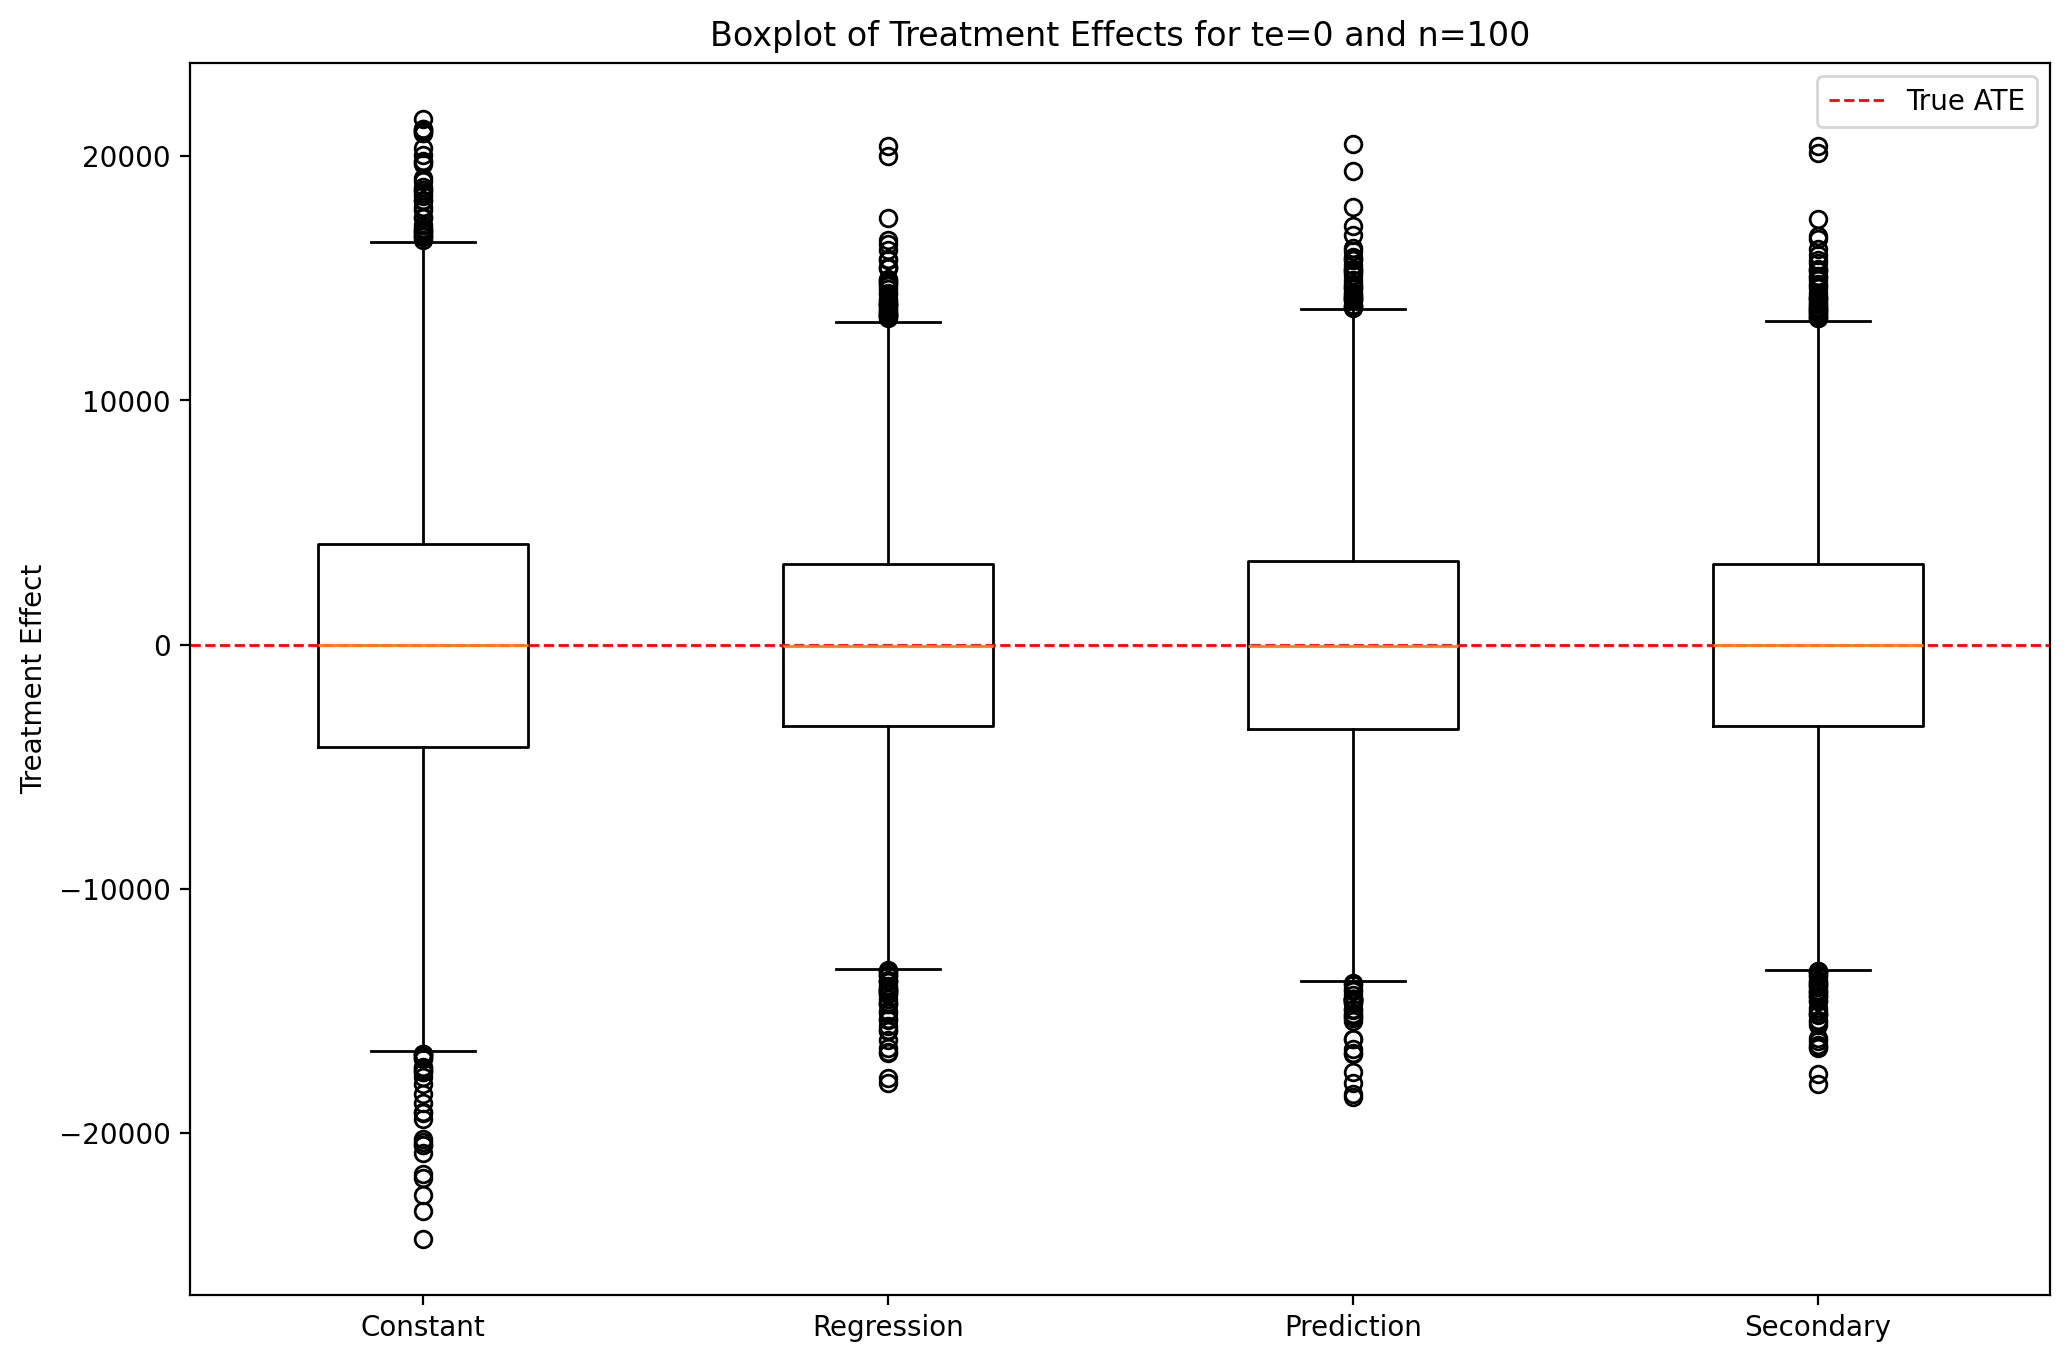

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_61471/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


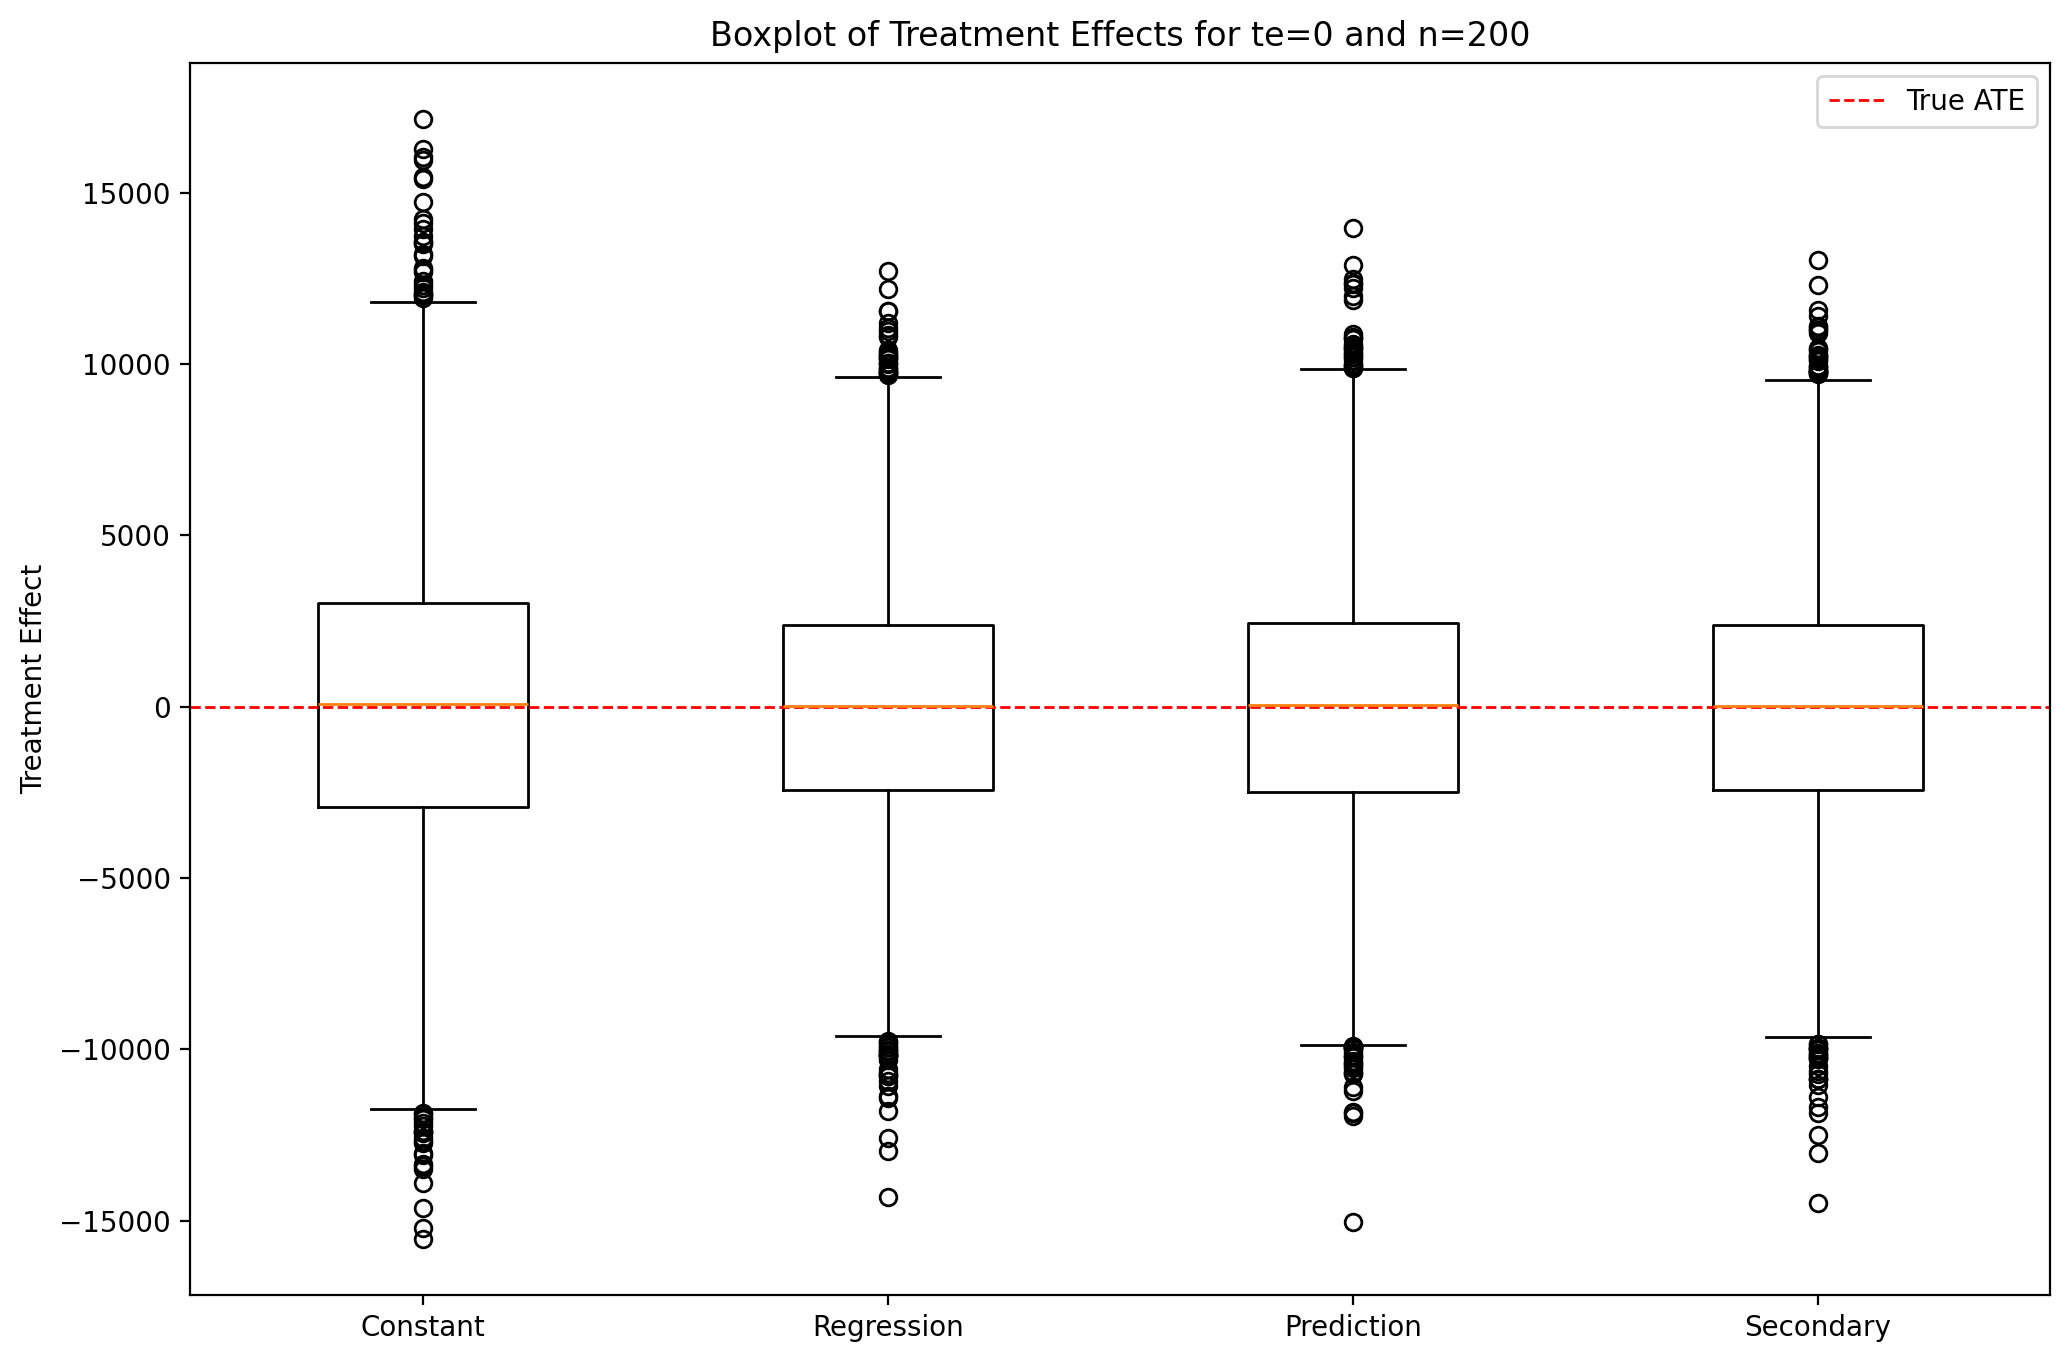

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_61471/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


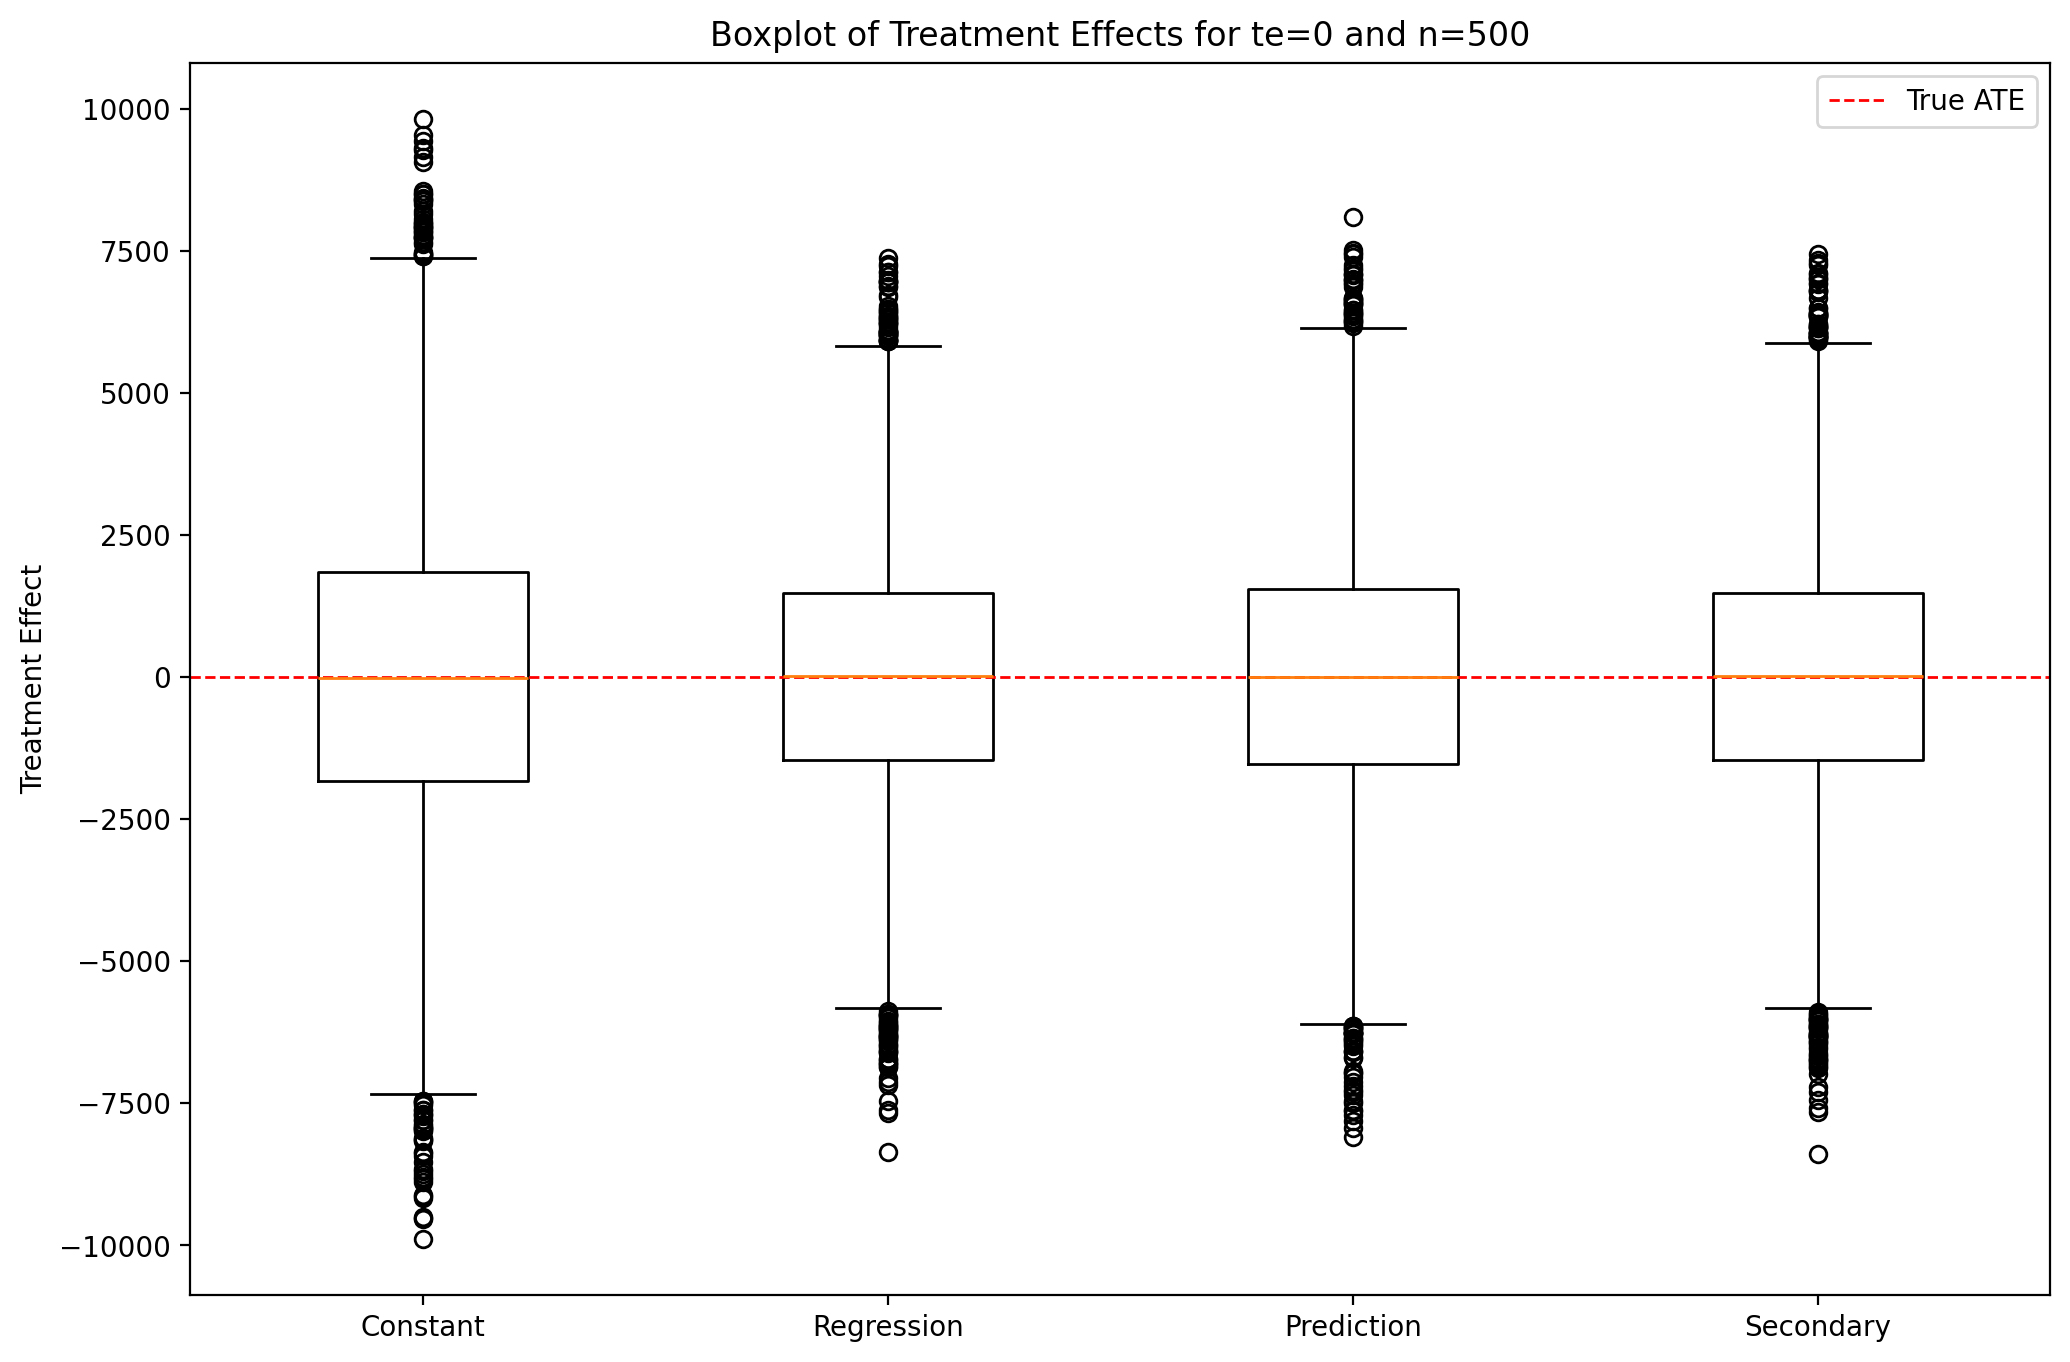

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_61471/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


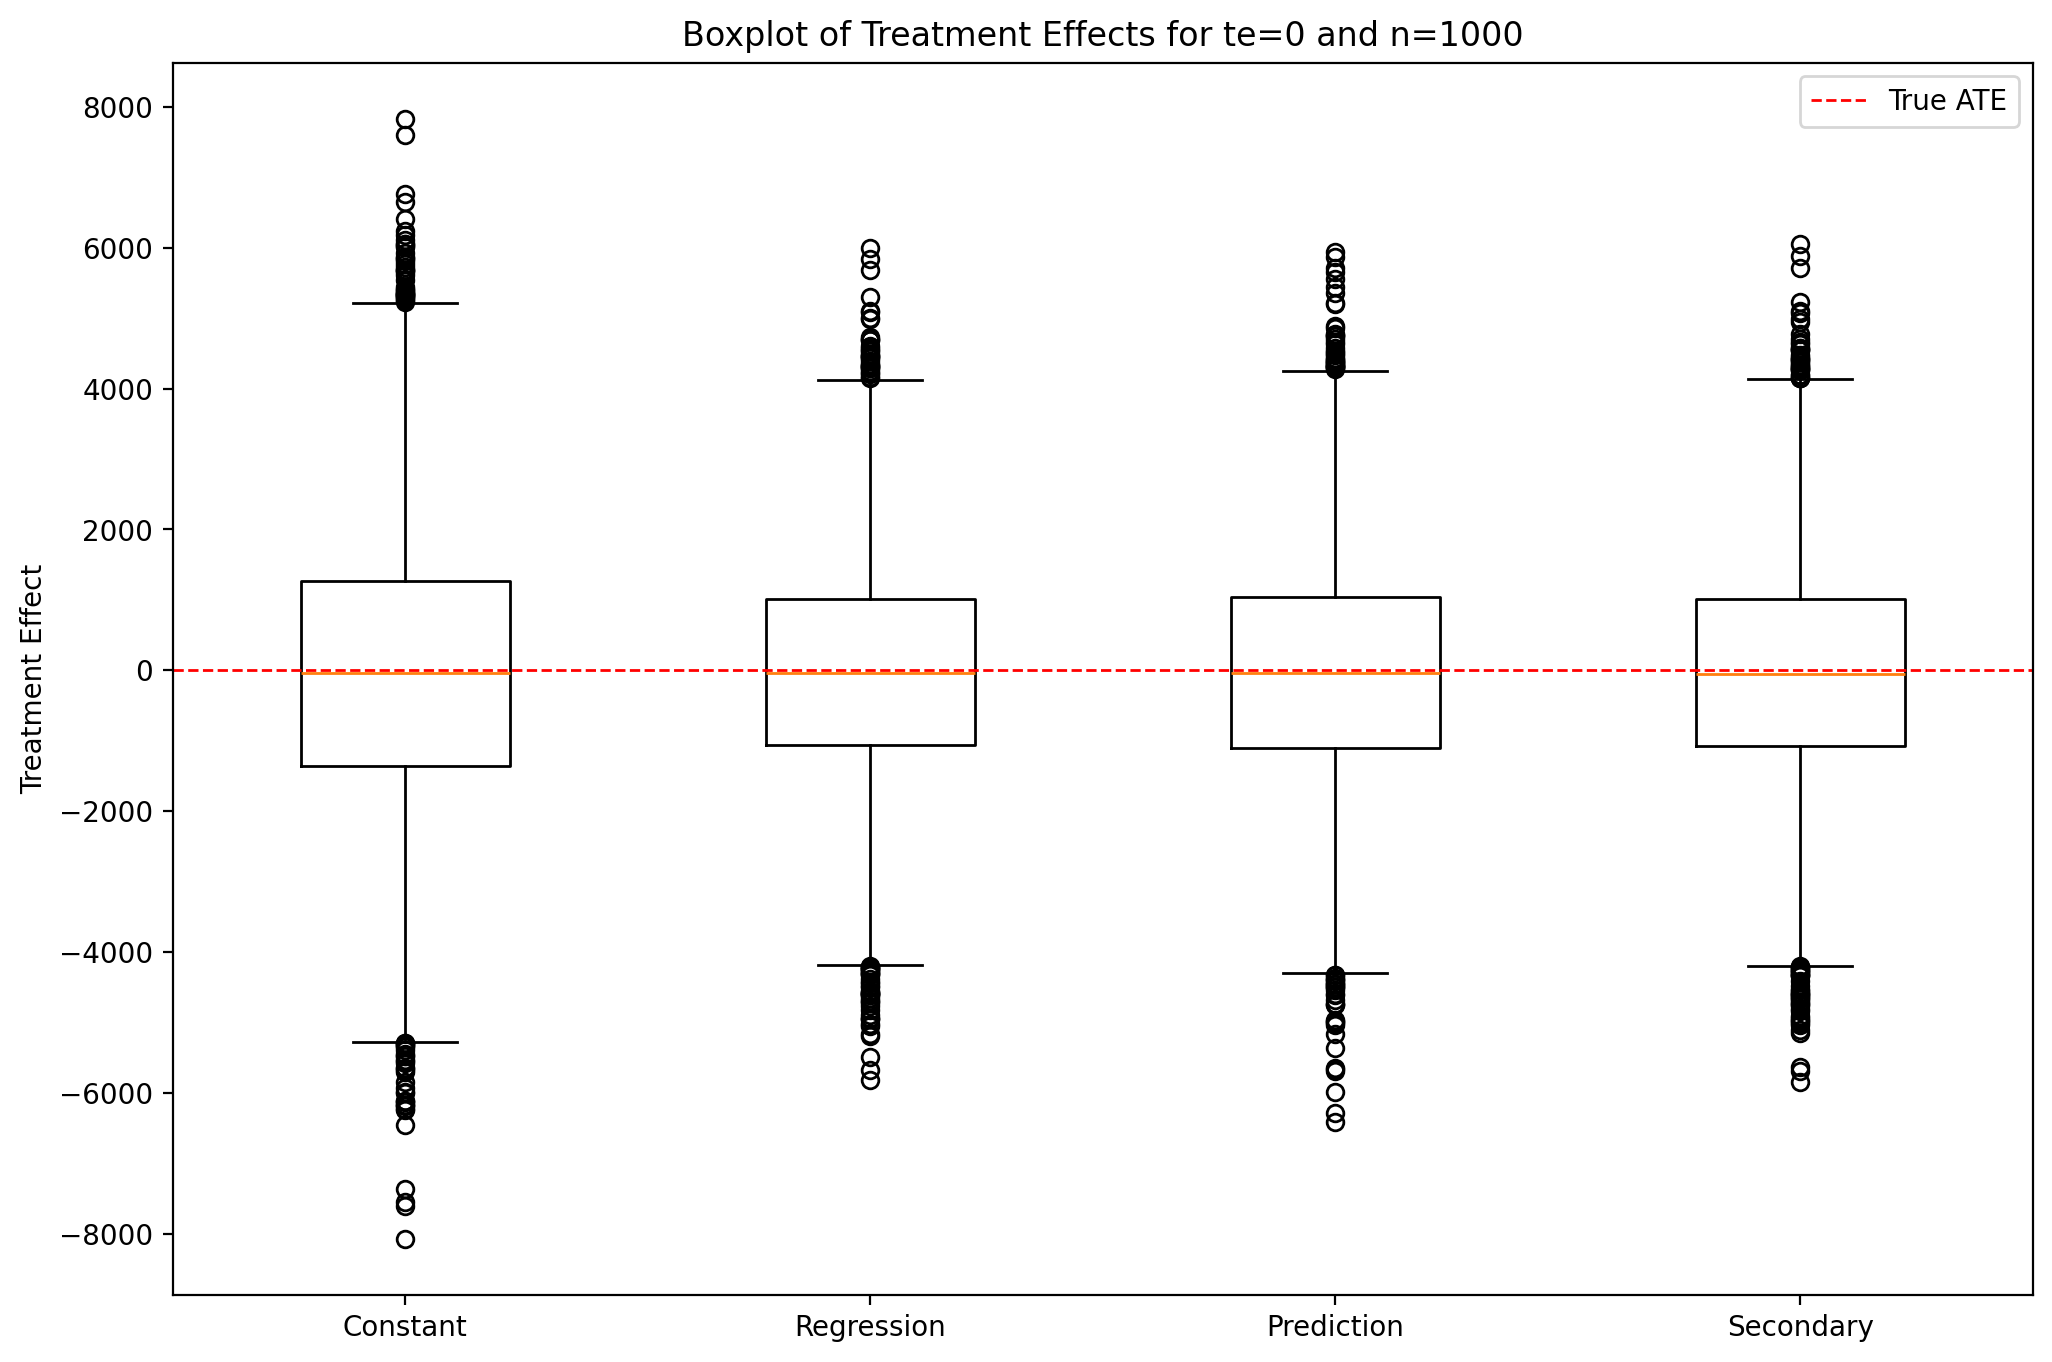

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_61471/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


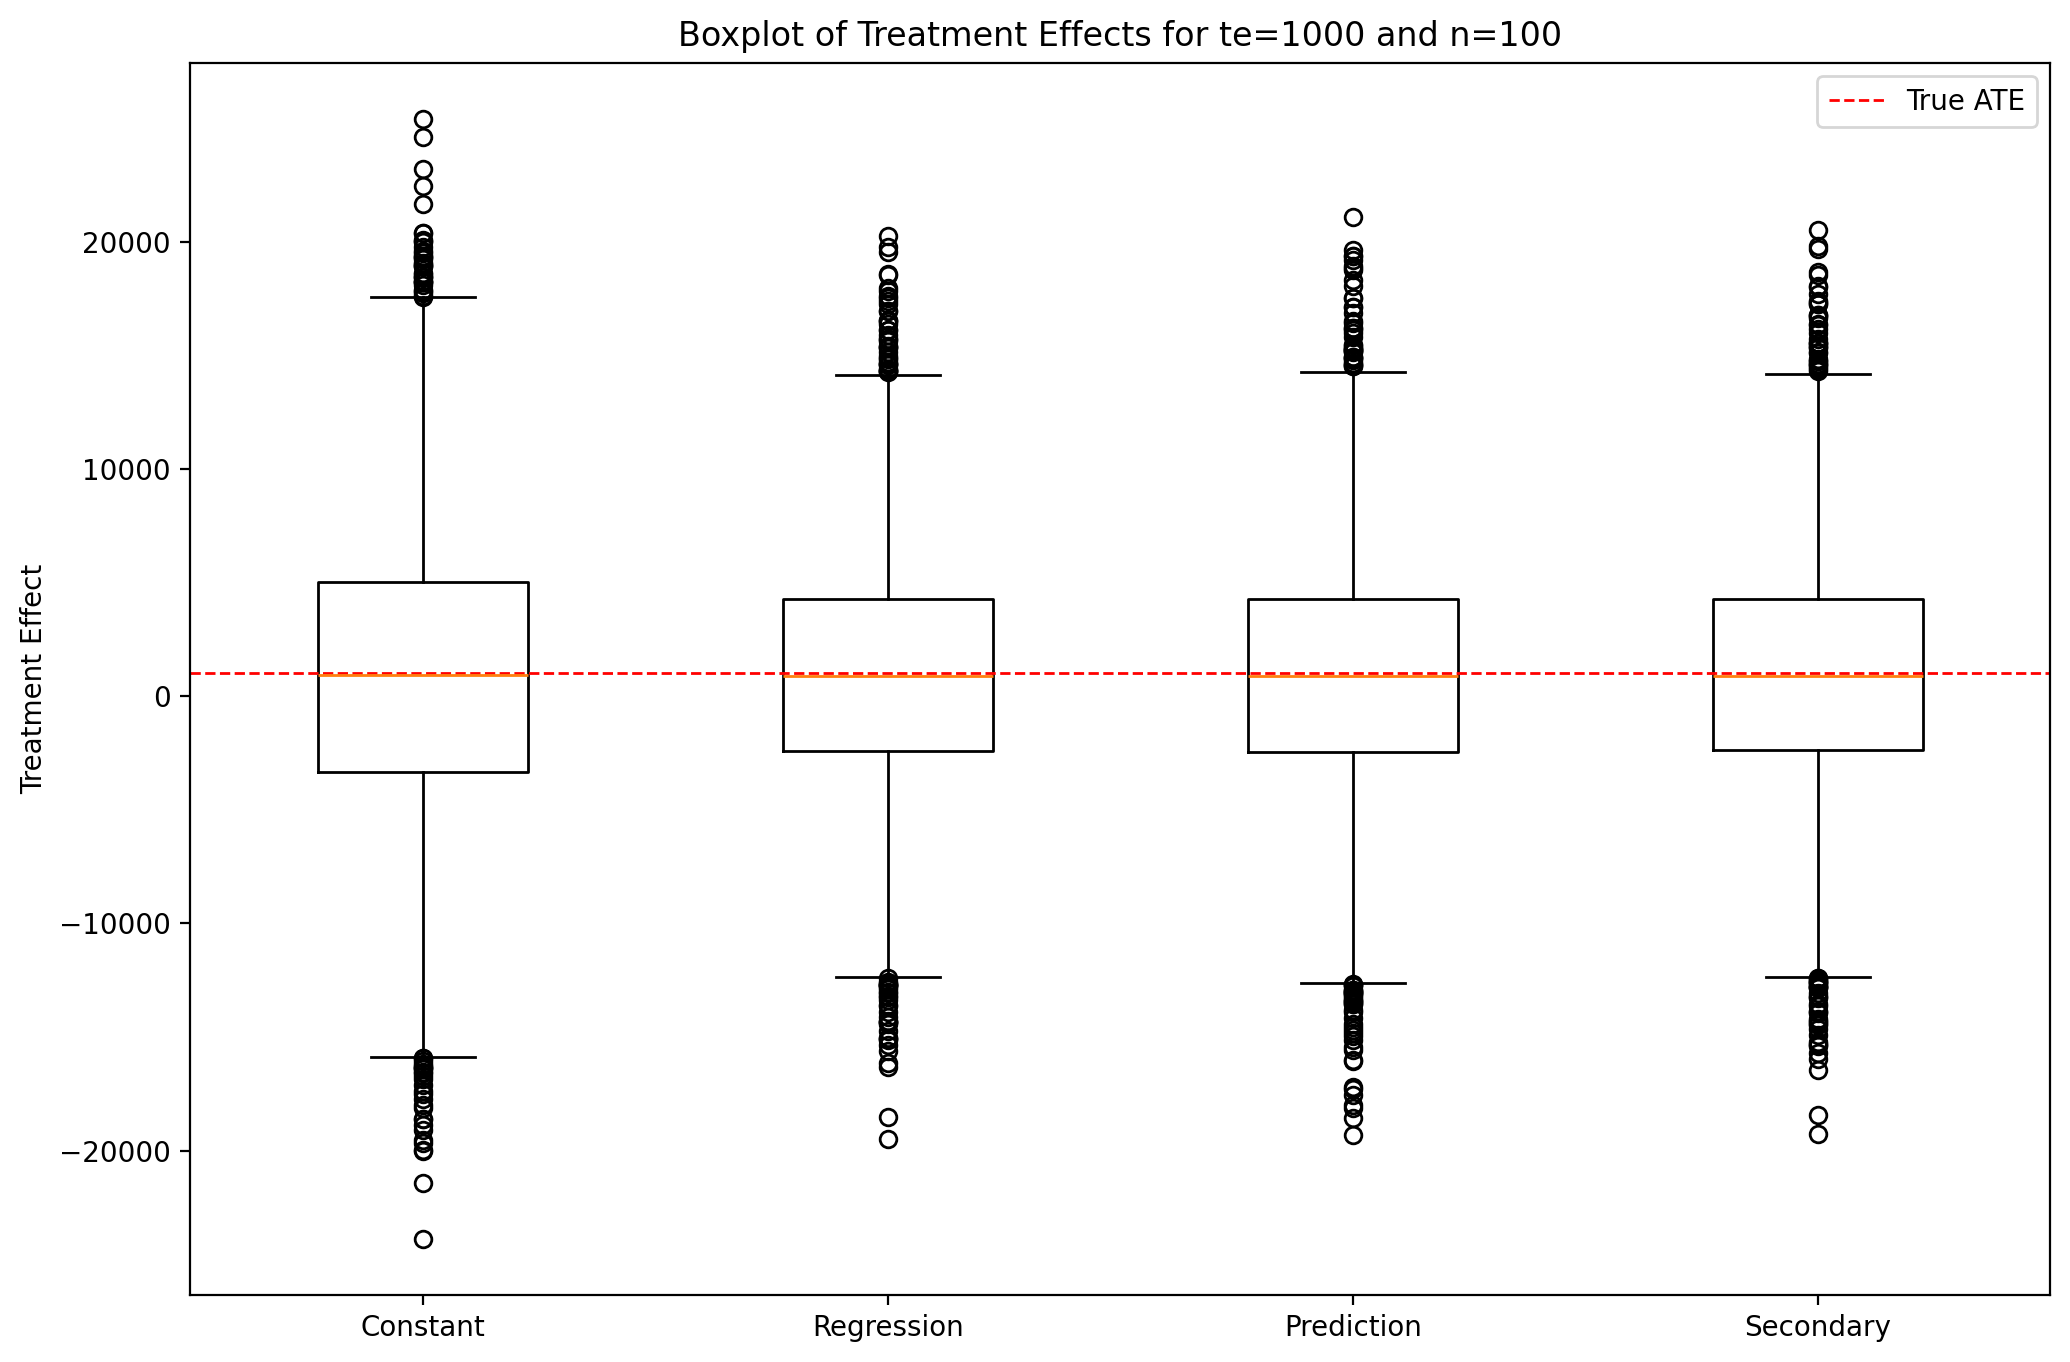

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_61471/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


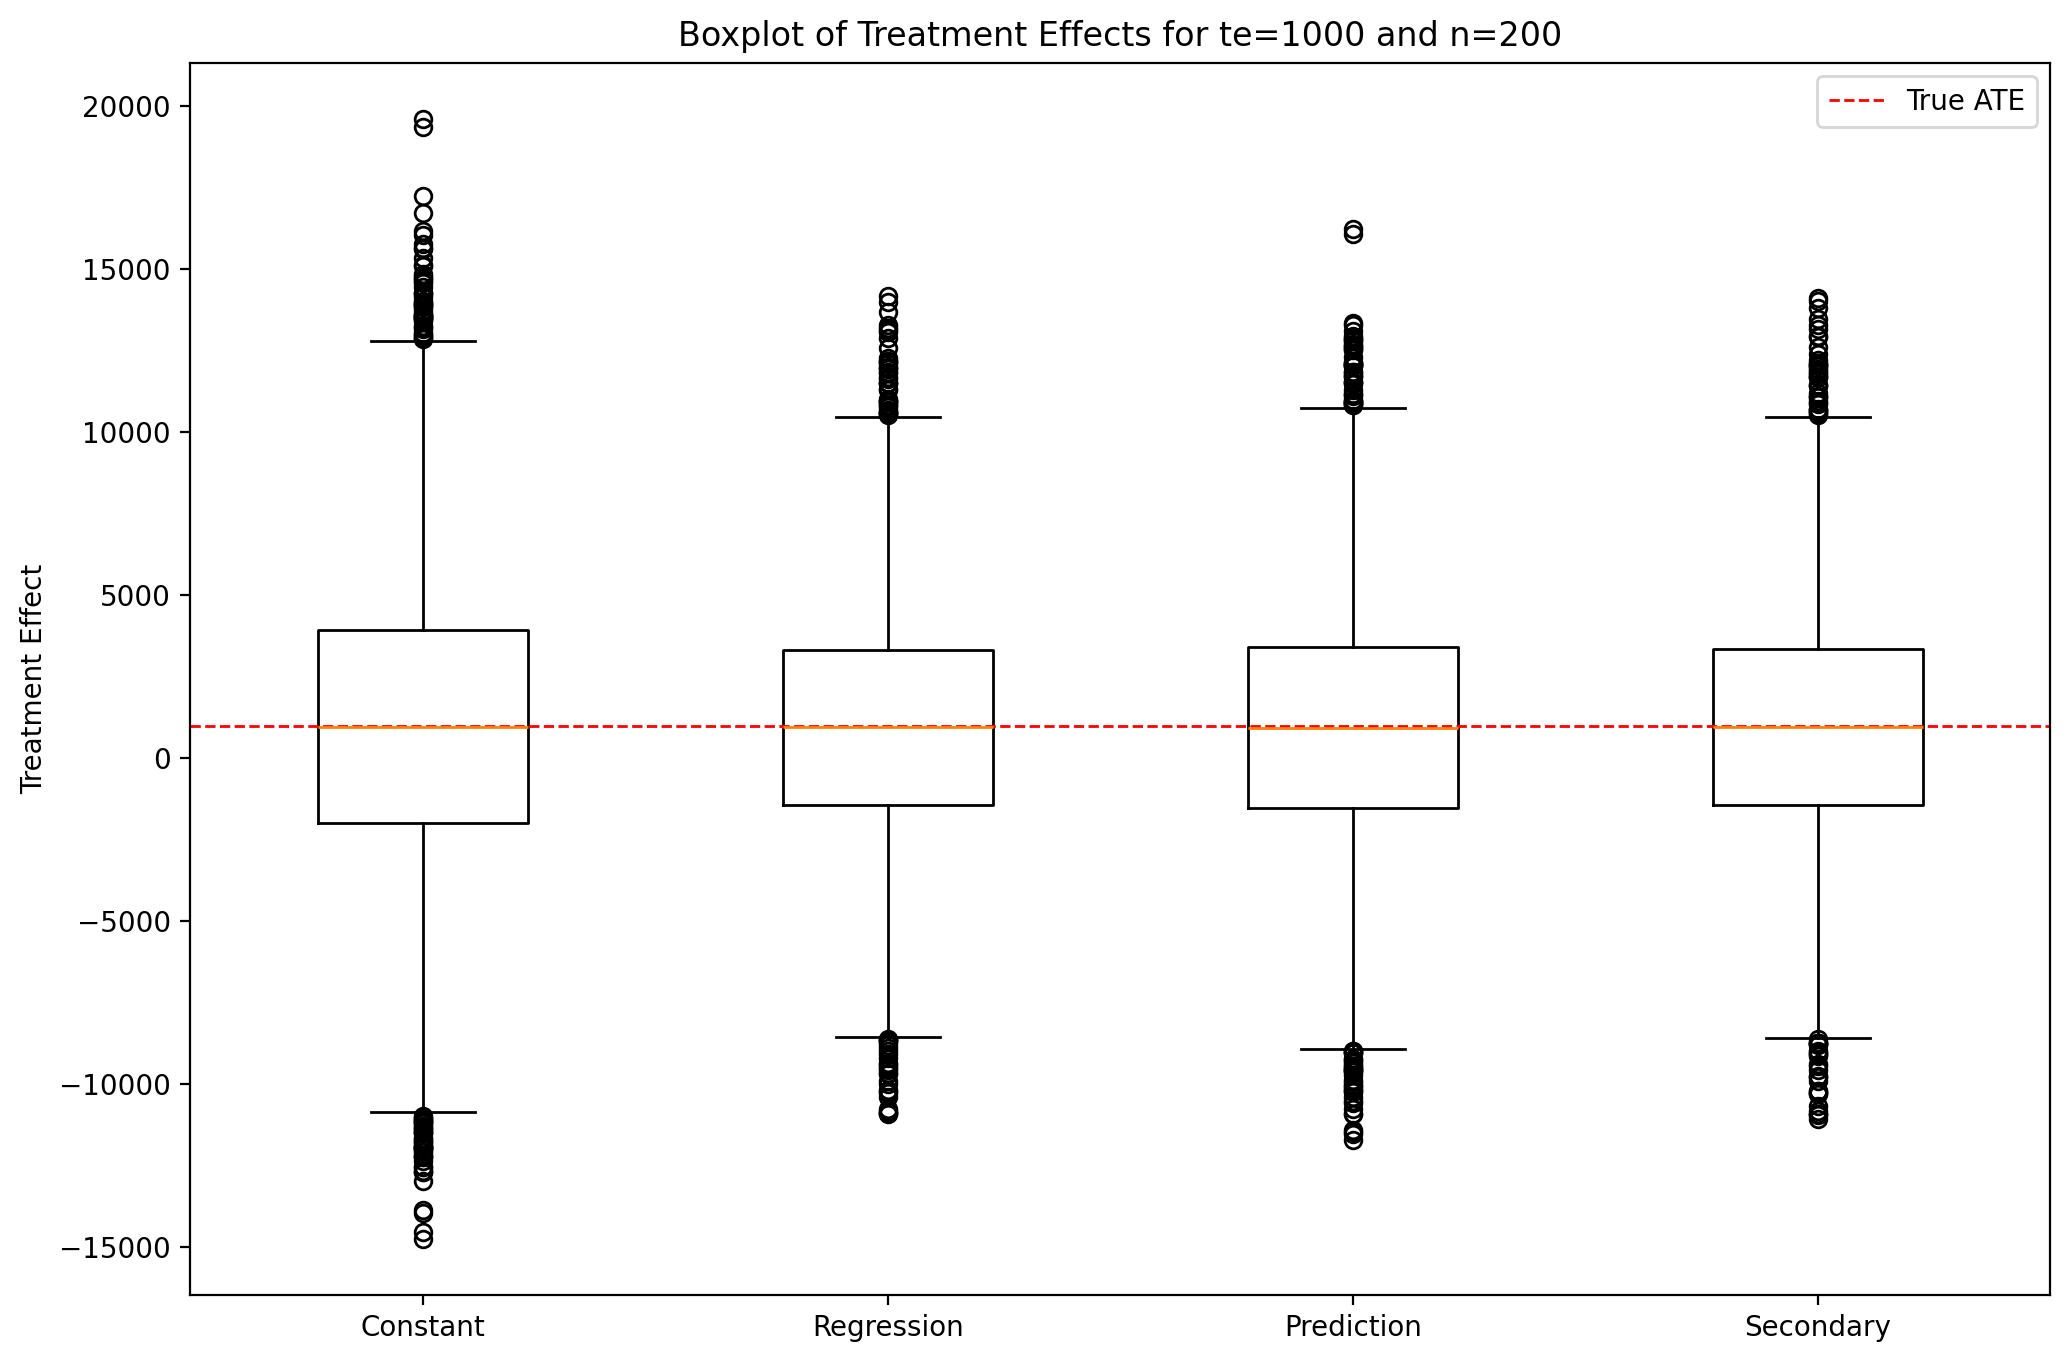

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_61471/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


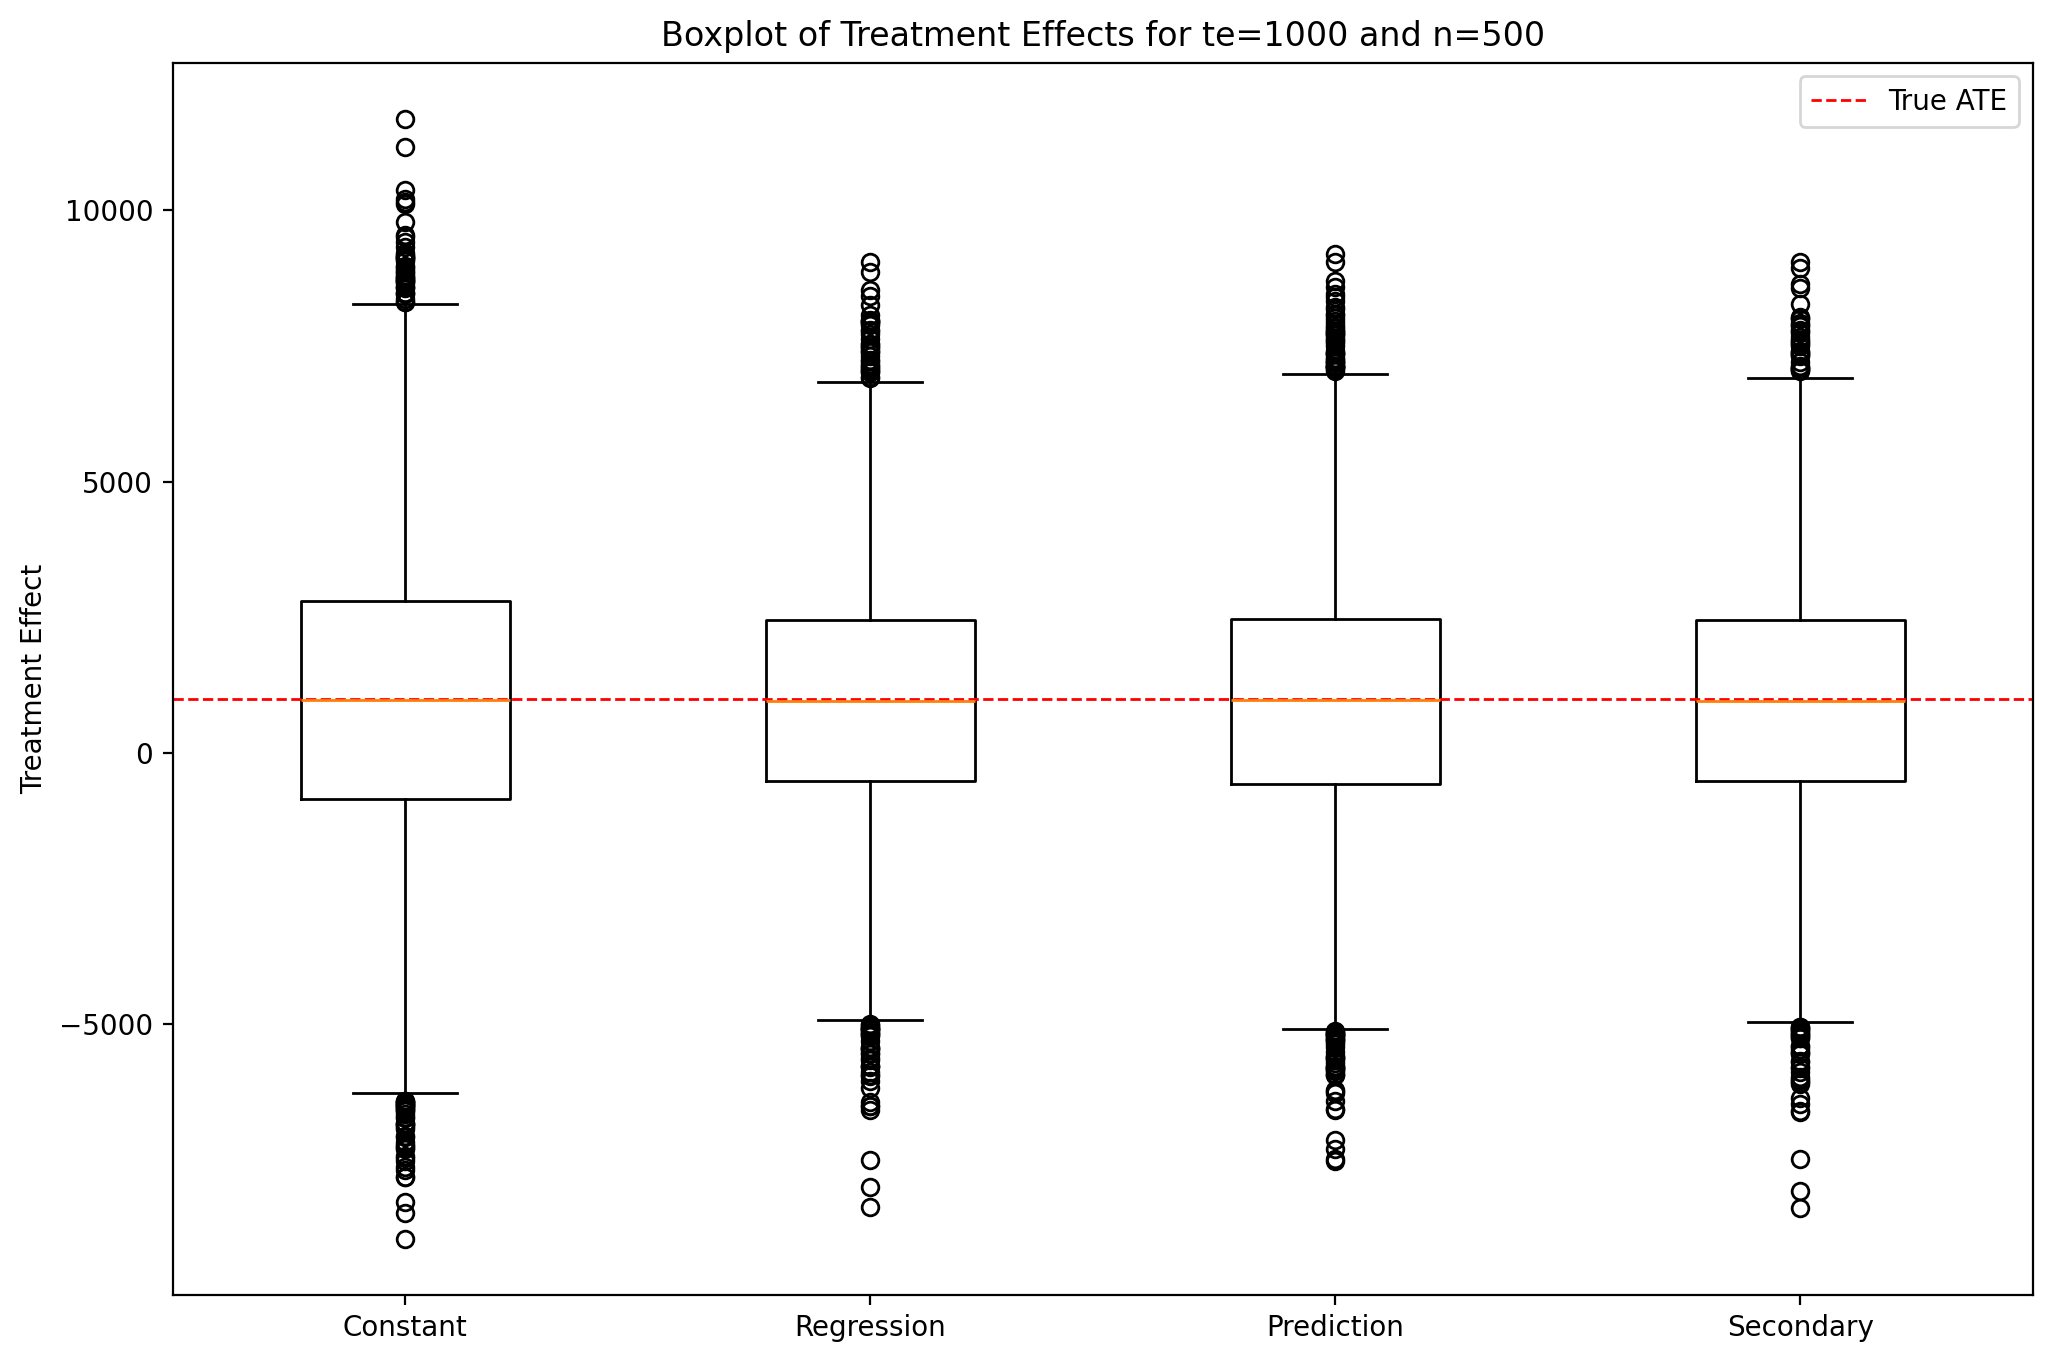

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_61471/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


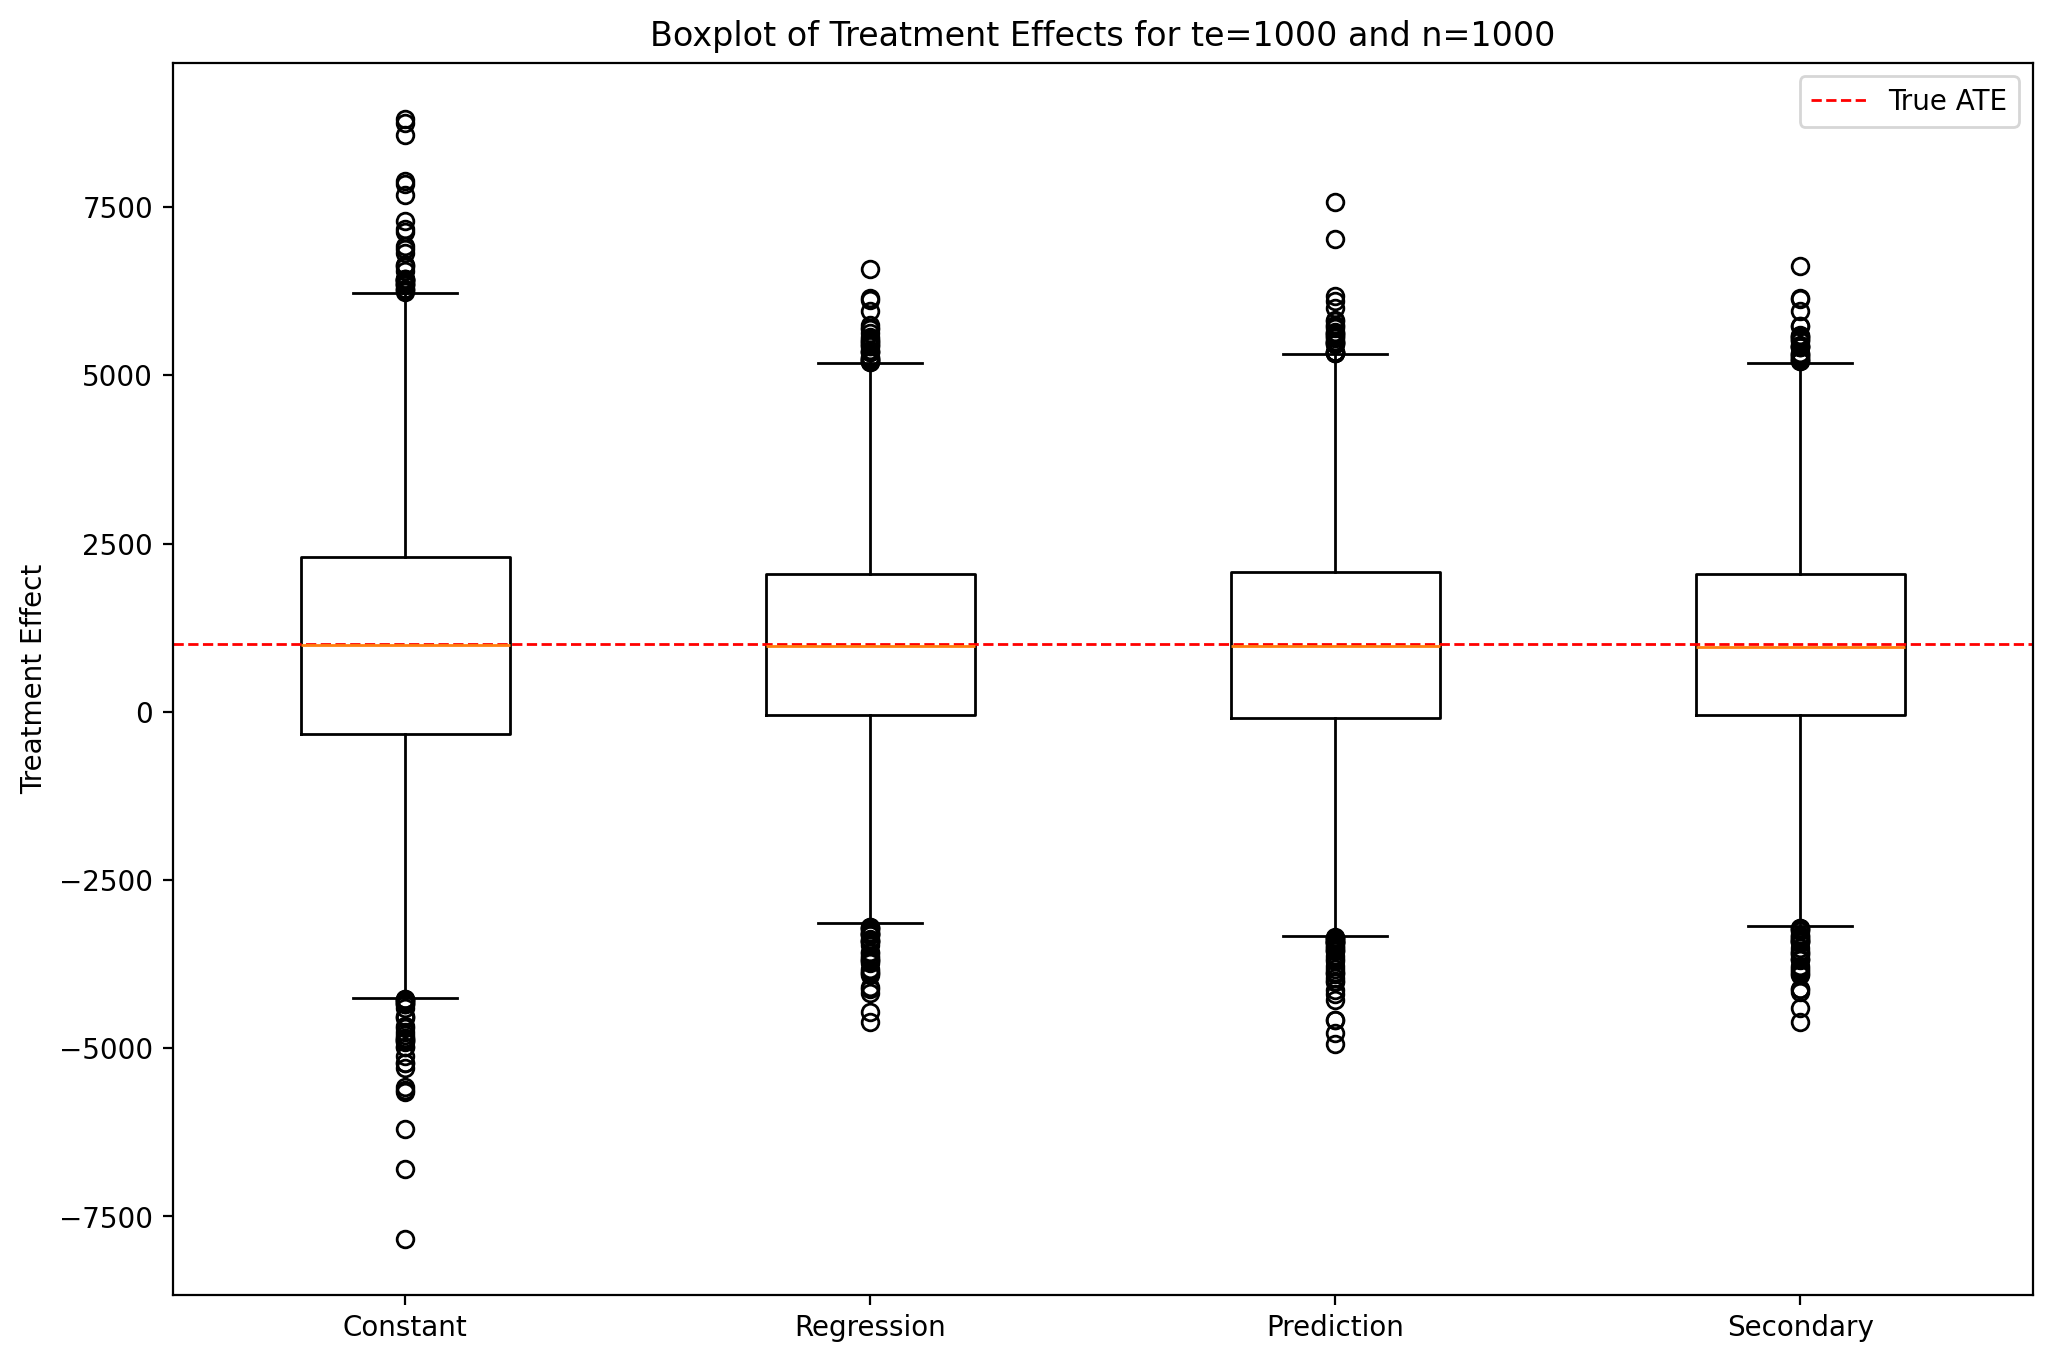

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_61471/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


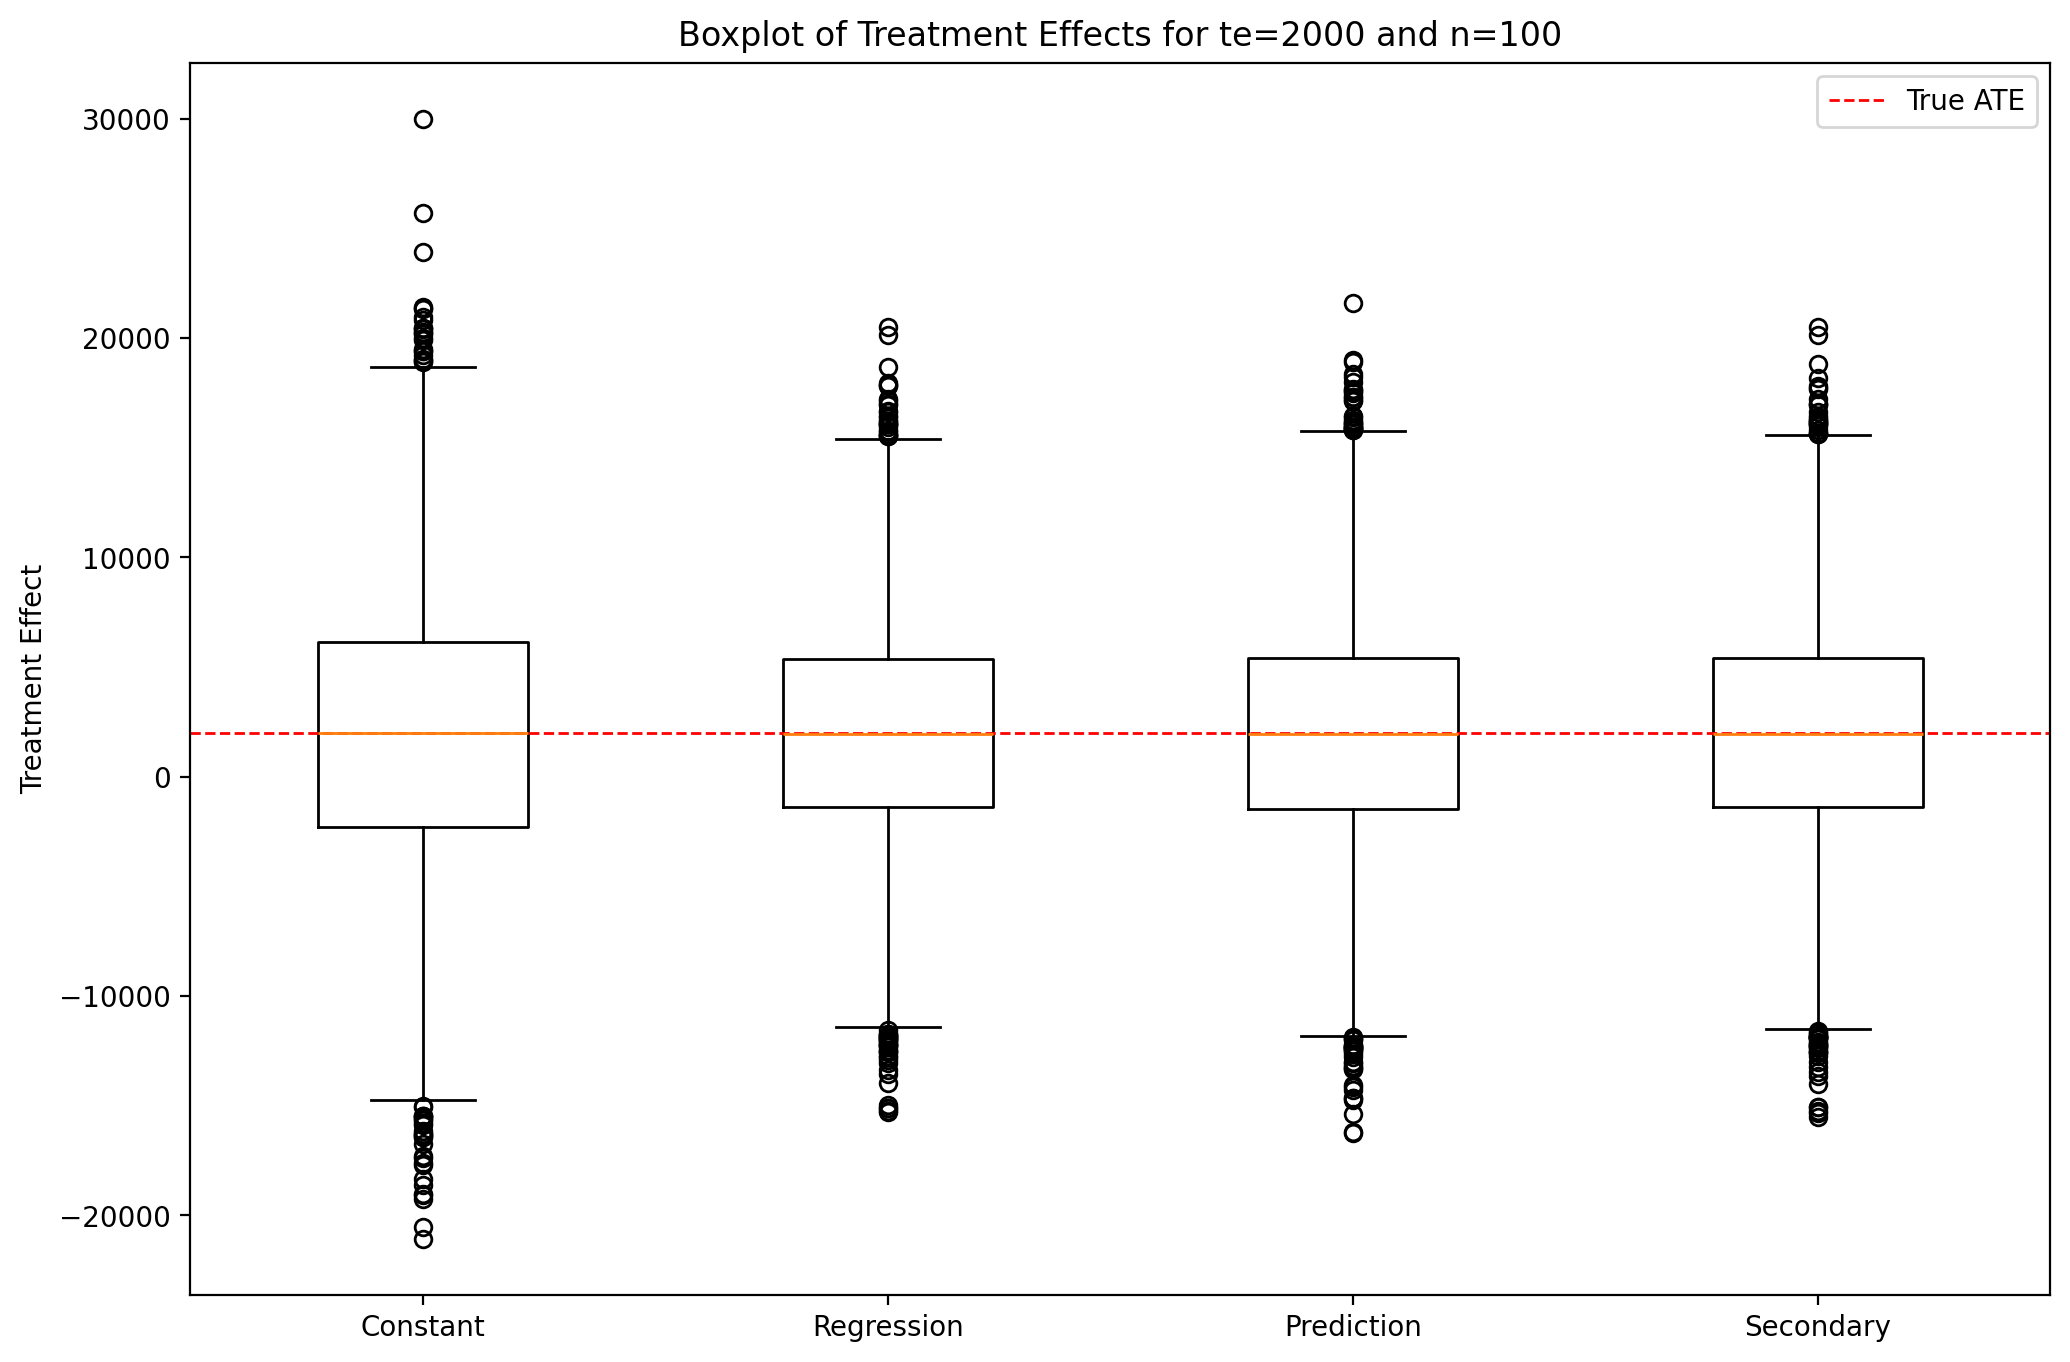

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_61471/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


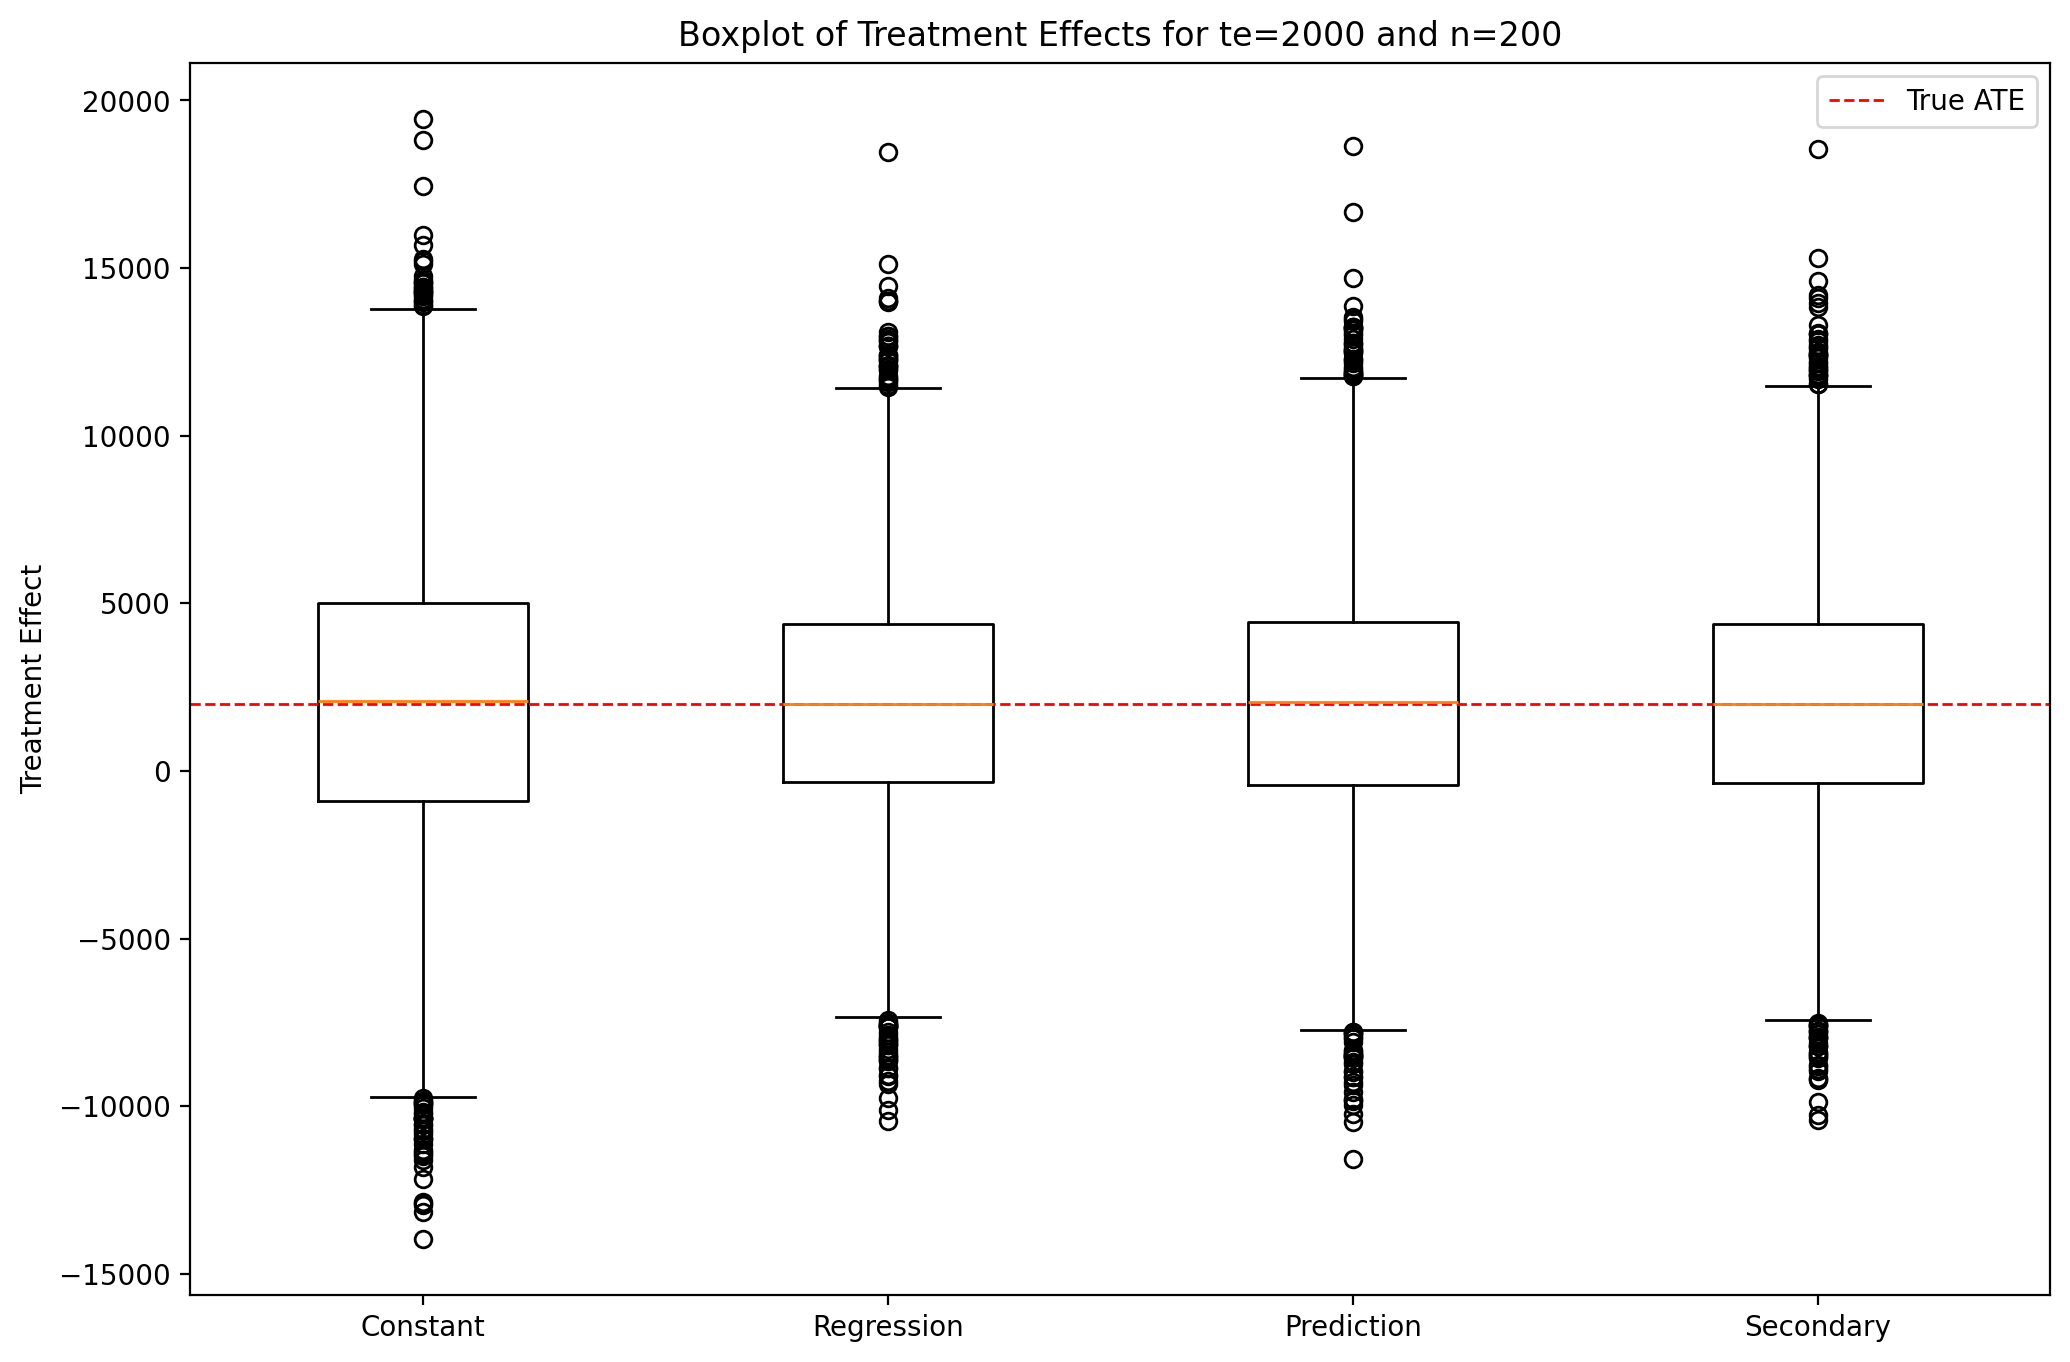

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_61471/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


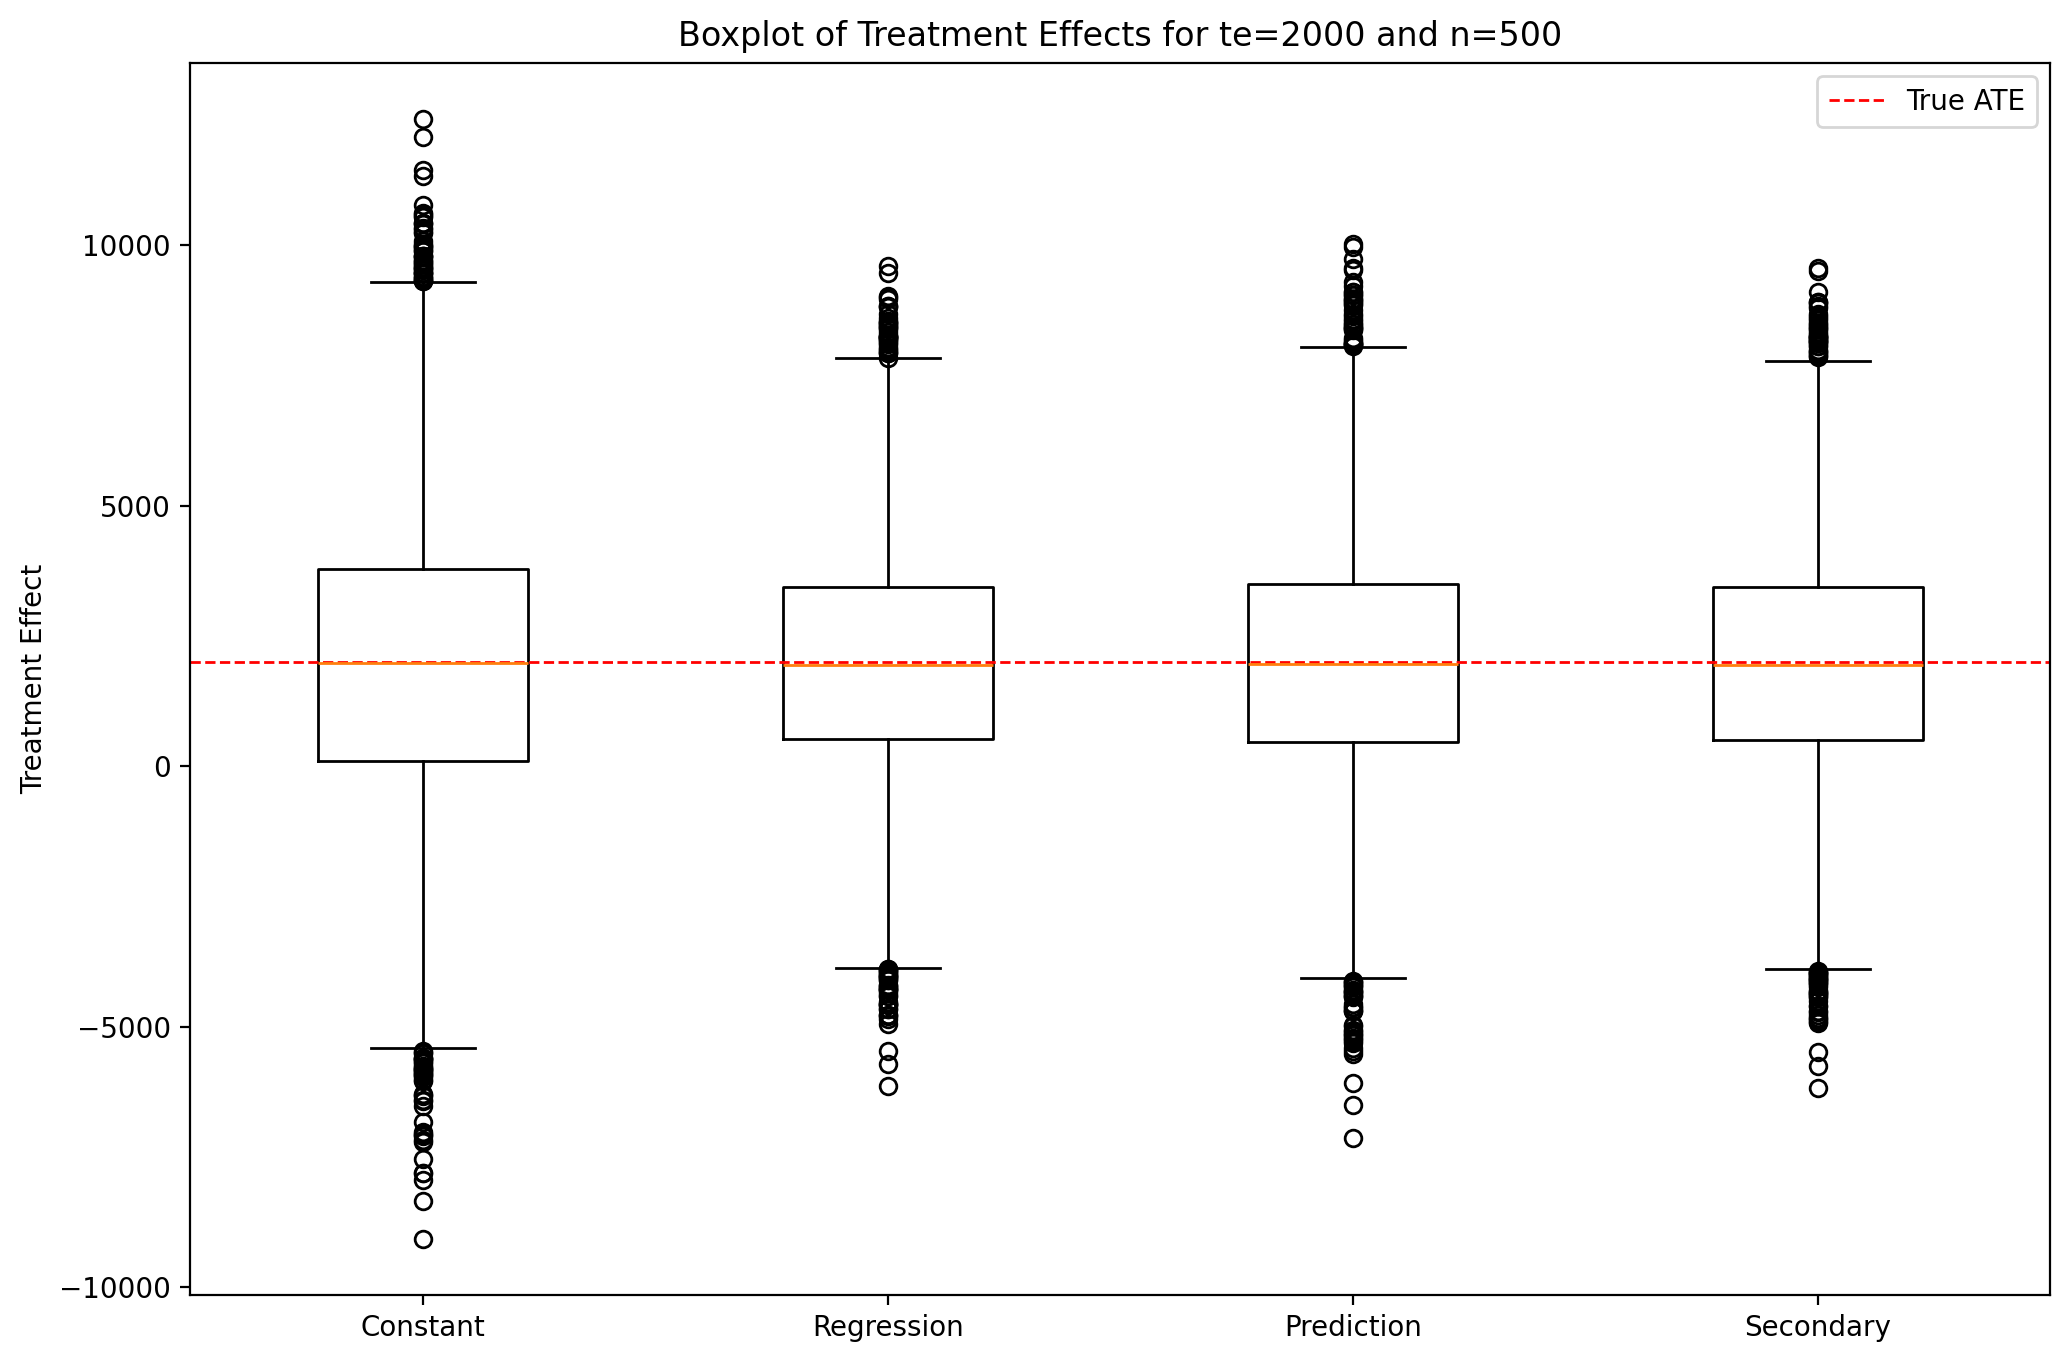

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_61471/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


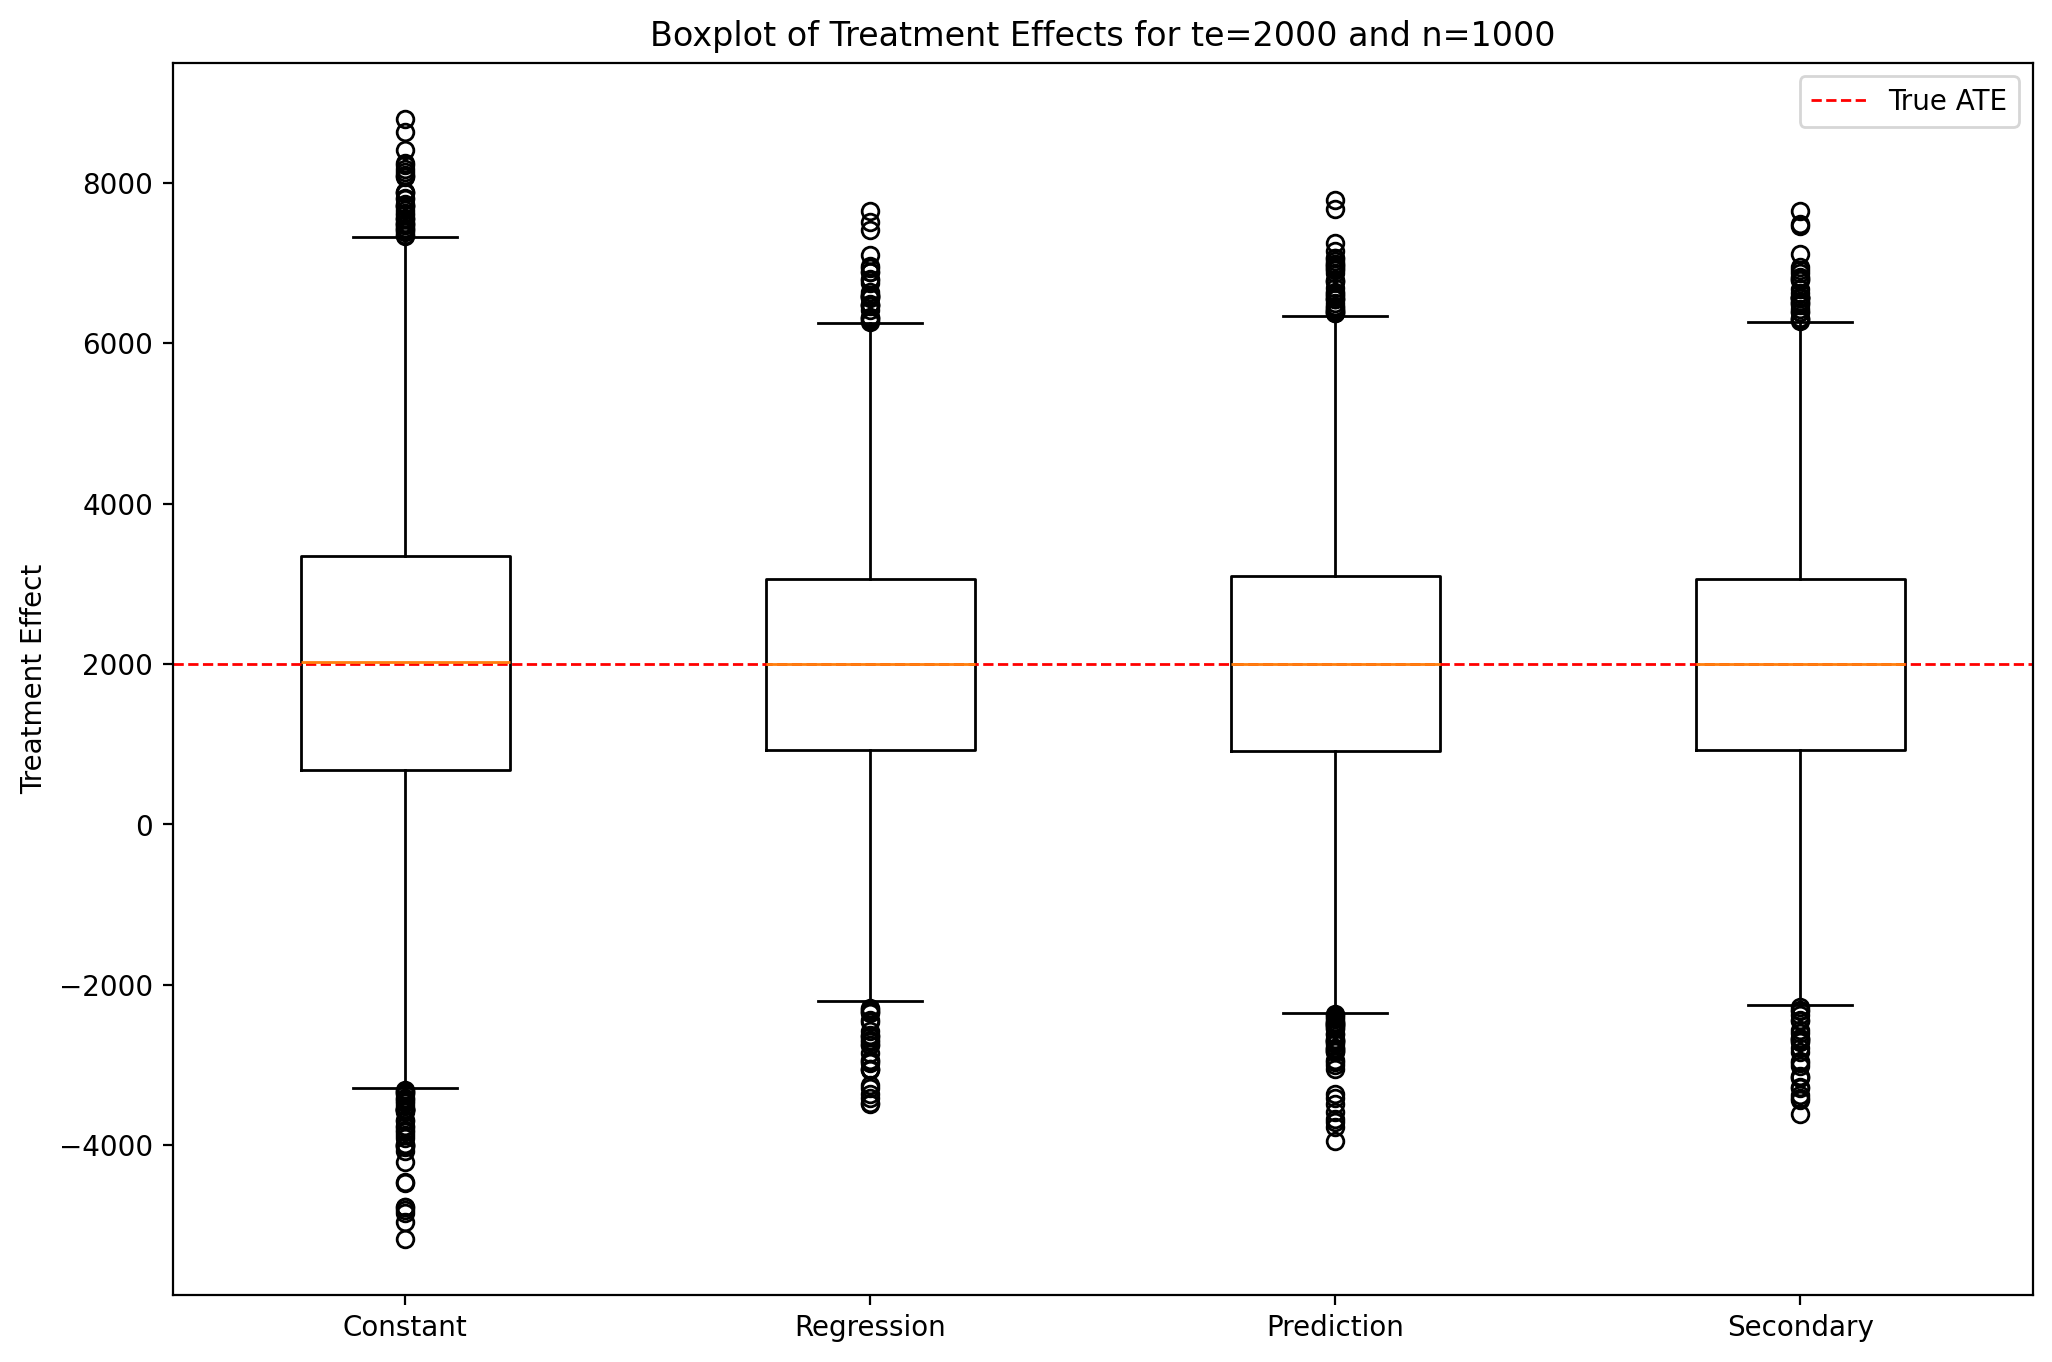

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_61471/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


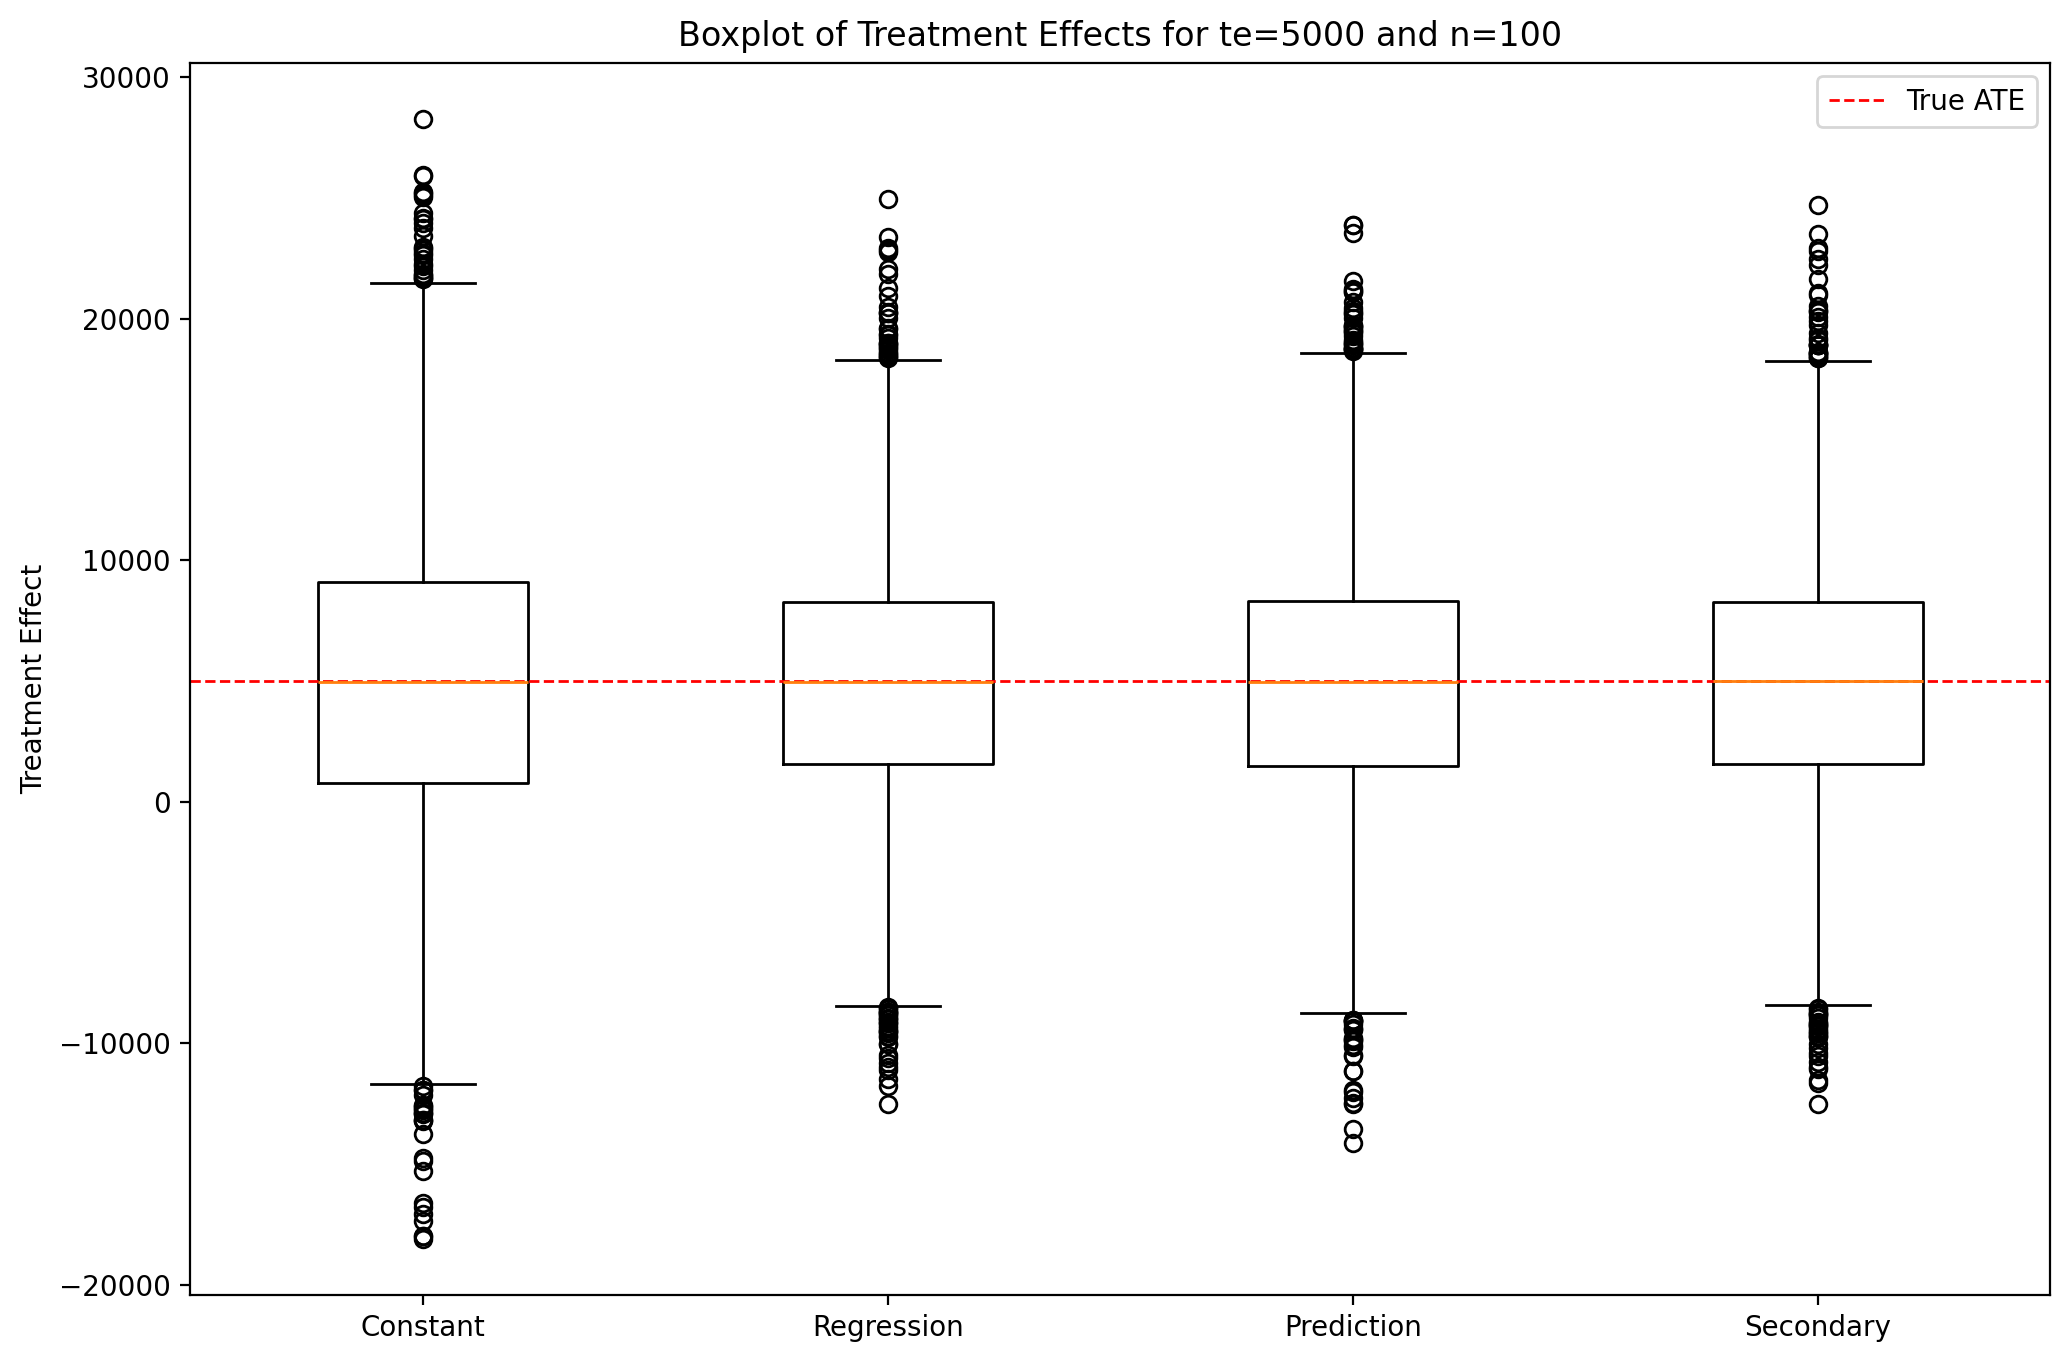

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_61471/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


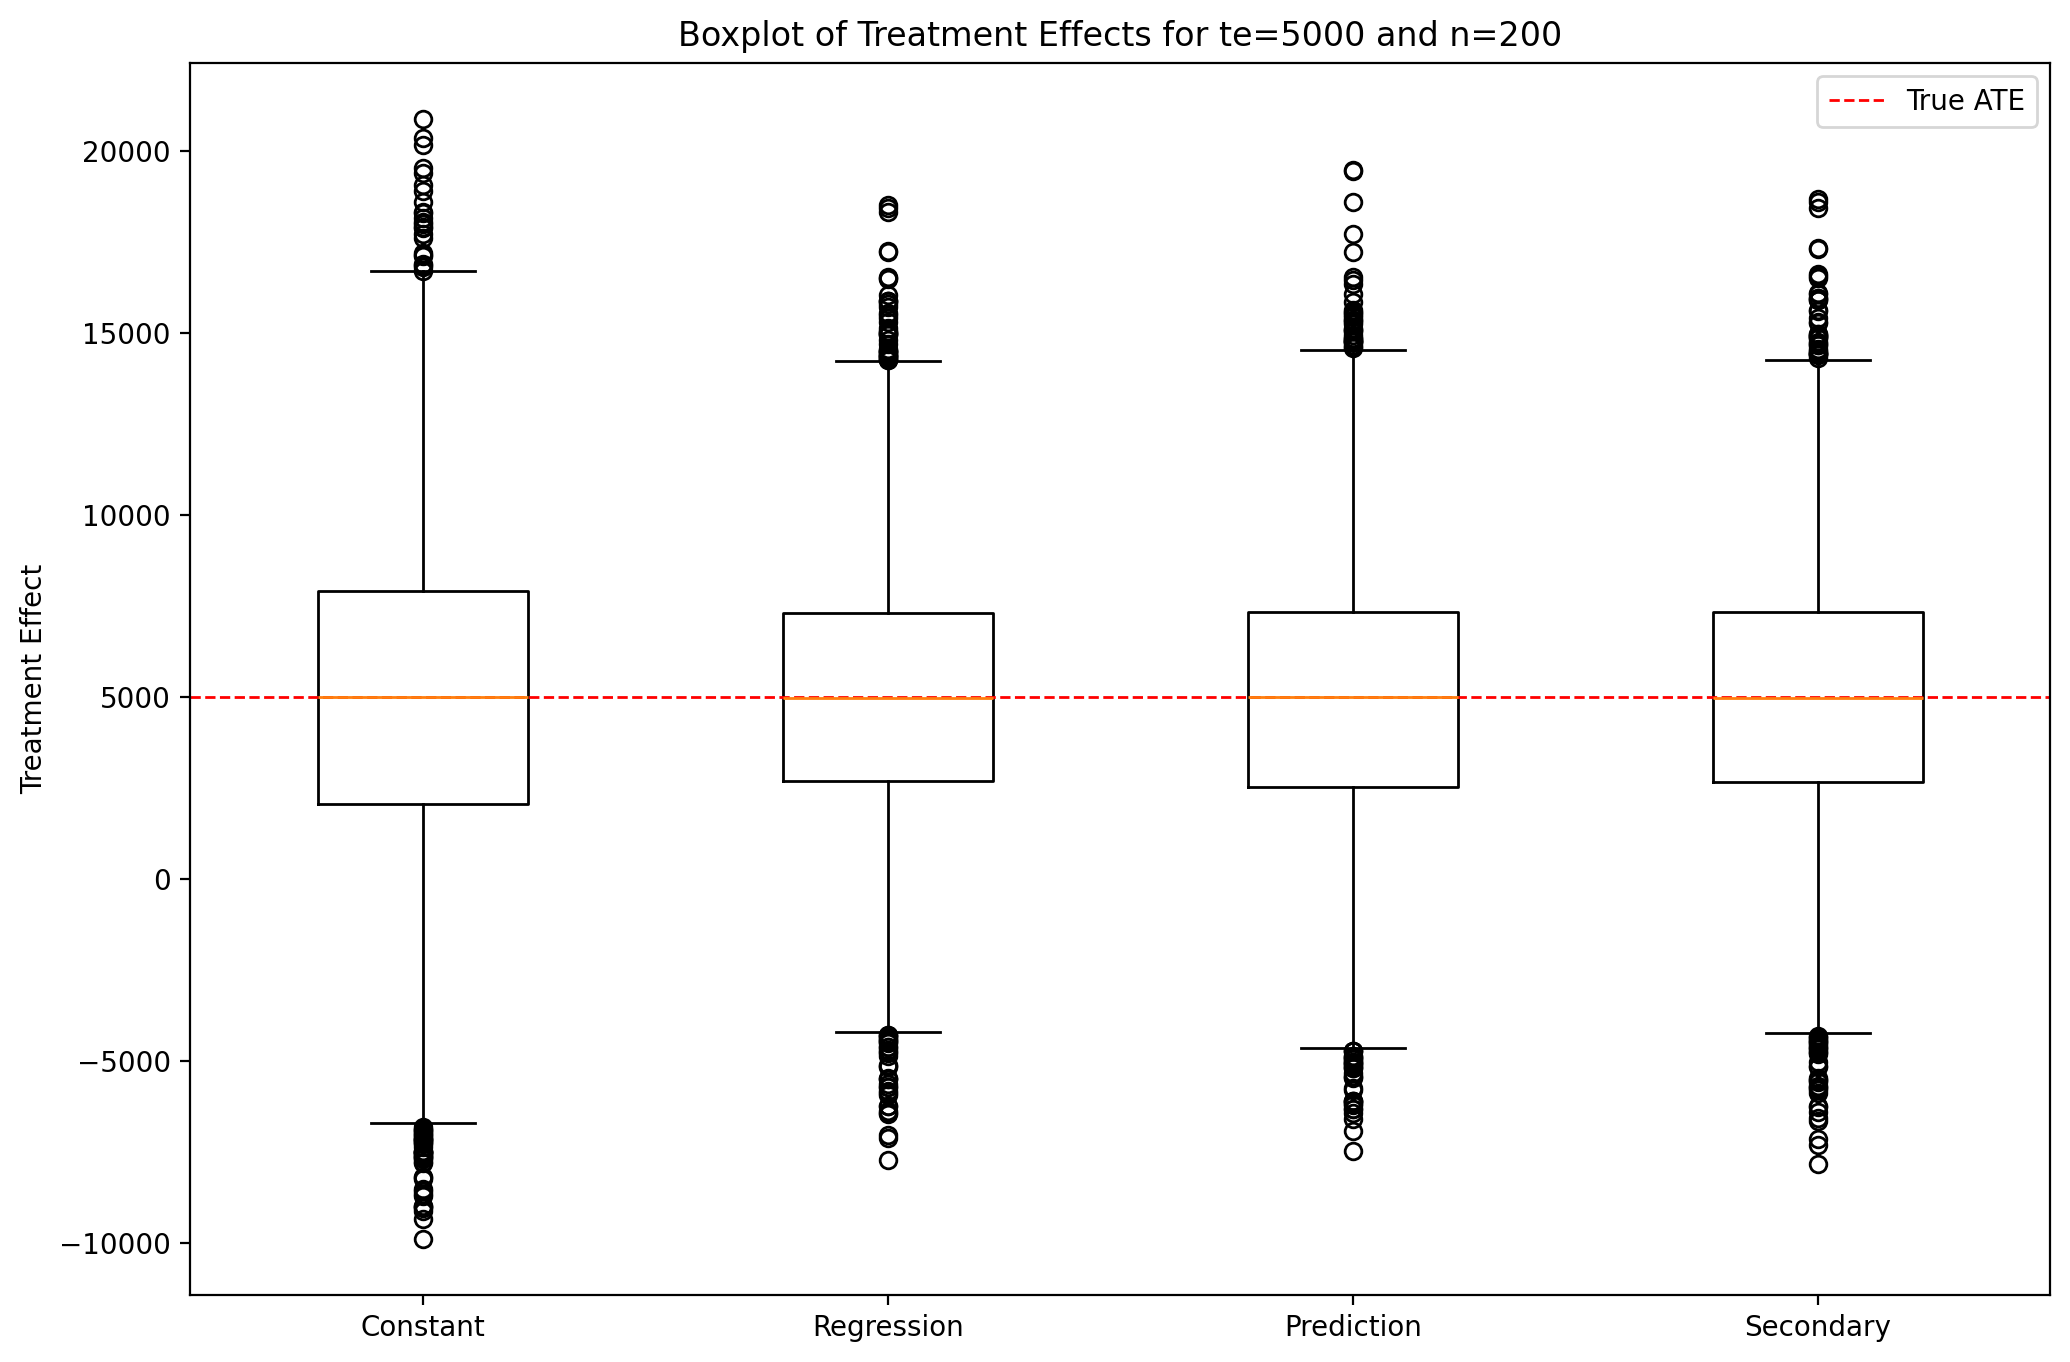

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_61471/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


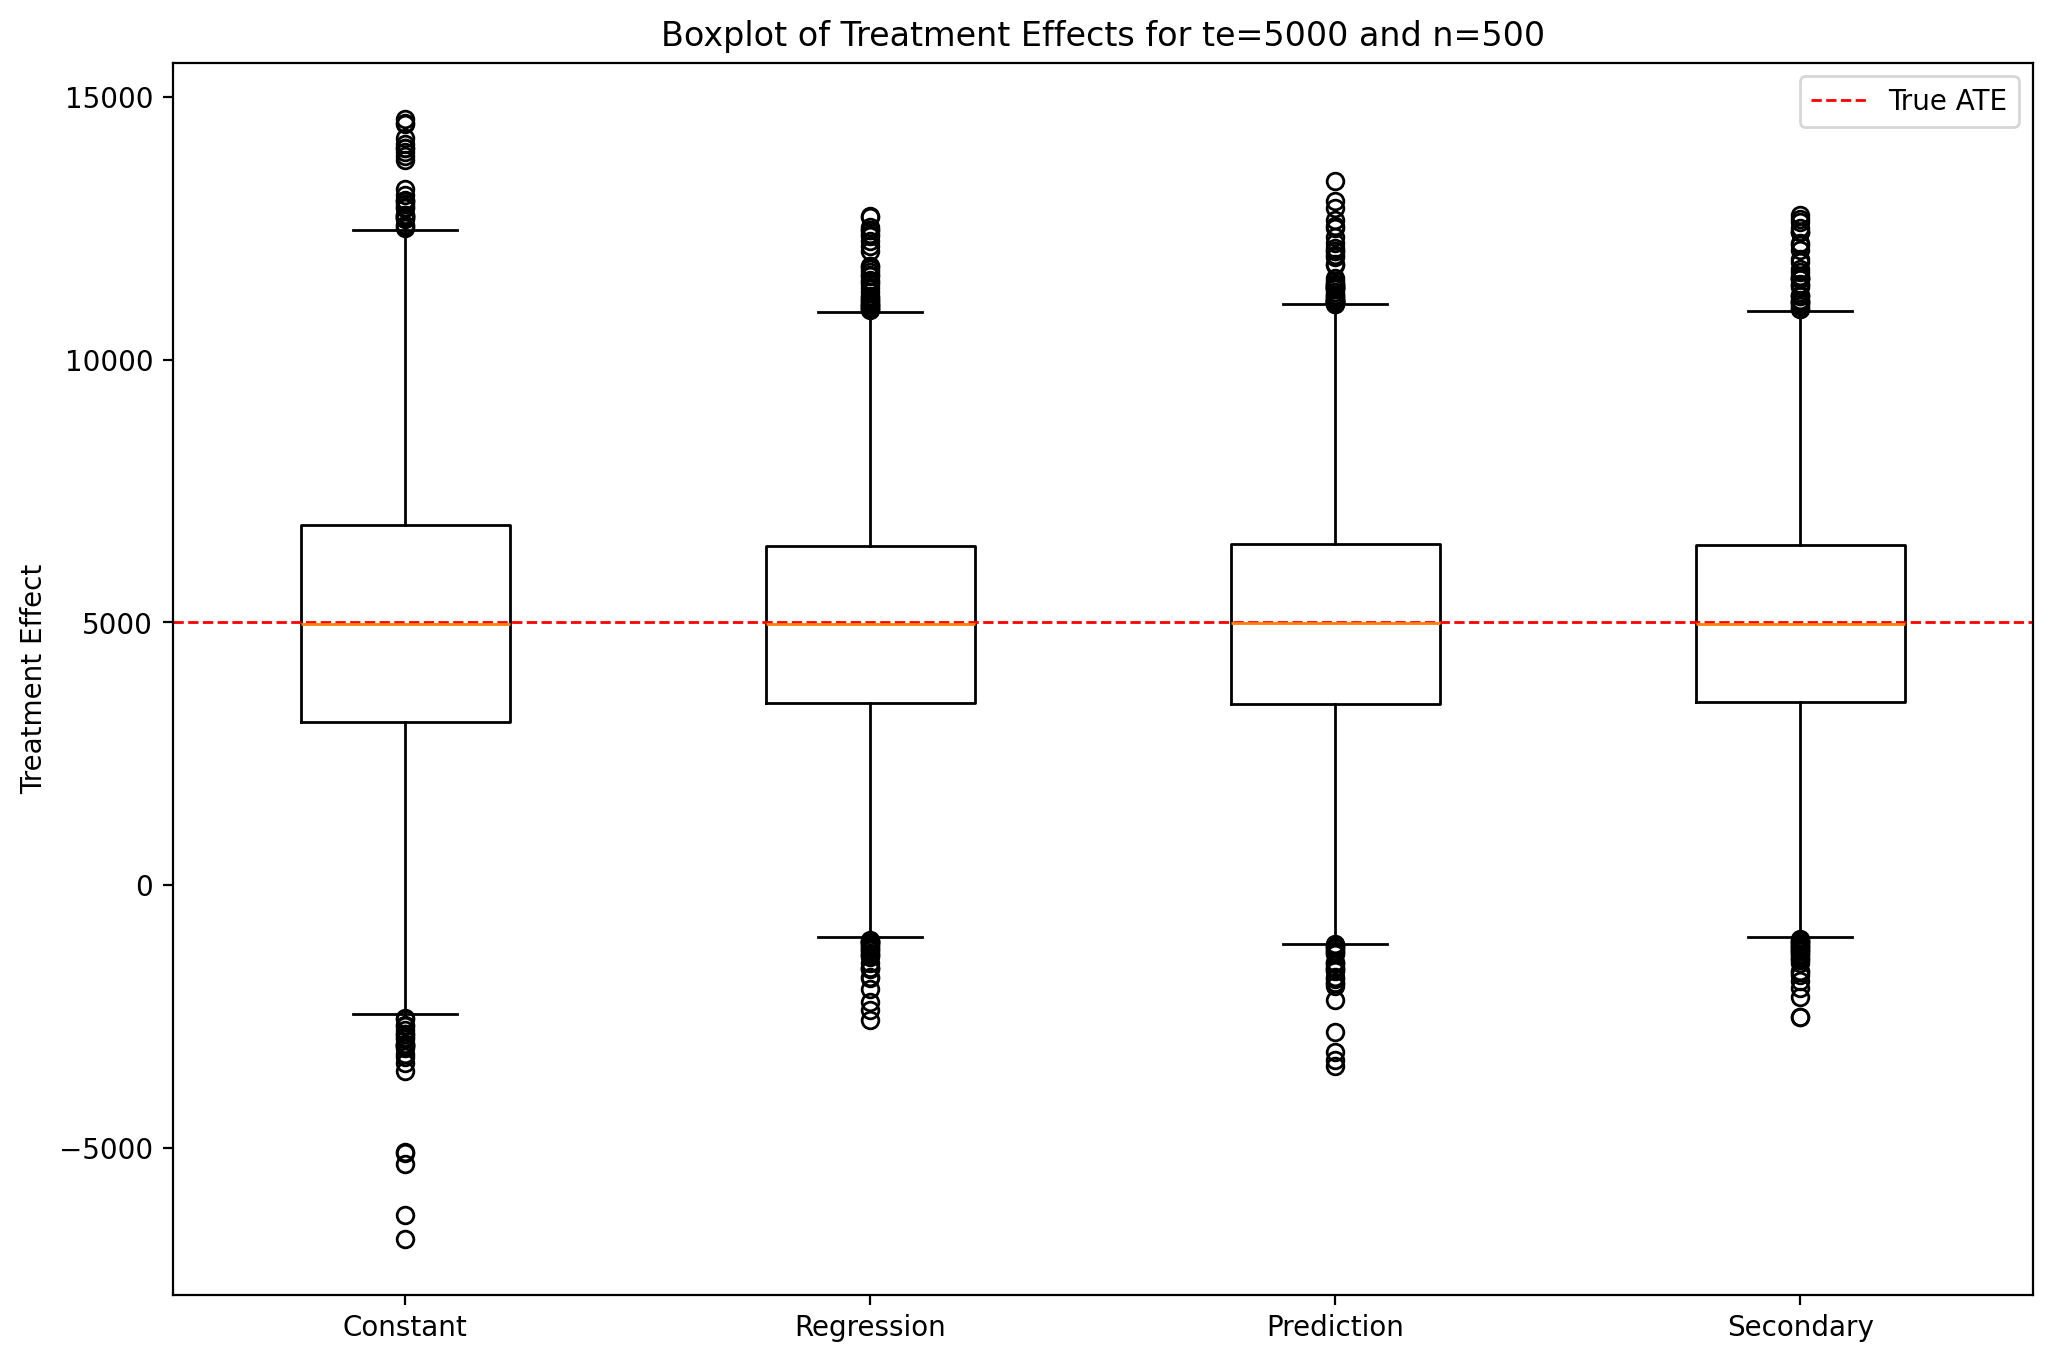

/var/folders/2q/xcbmvjmx41j5gdcs9llhh9qc0000gp/T/ipykernel_61471/1733256643.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],


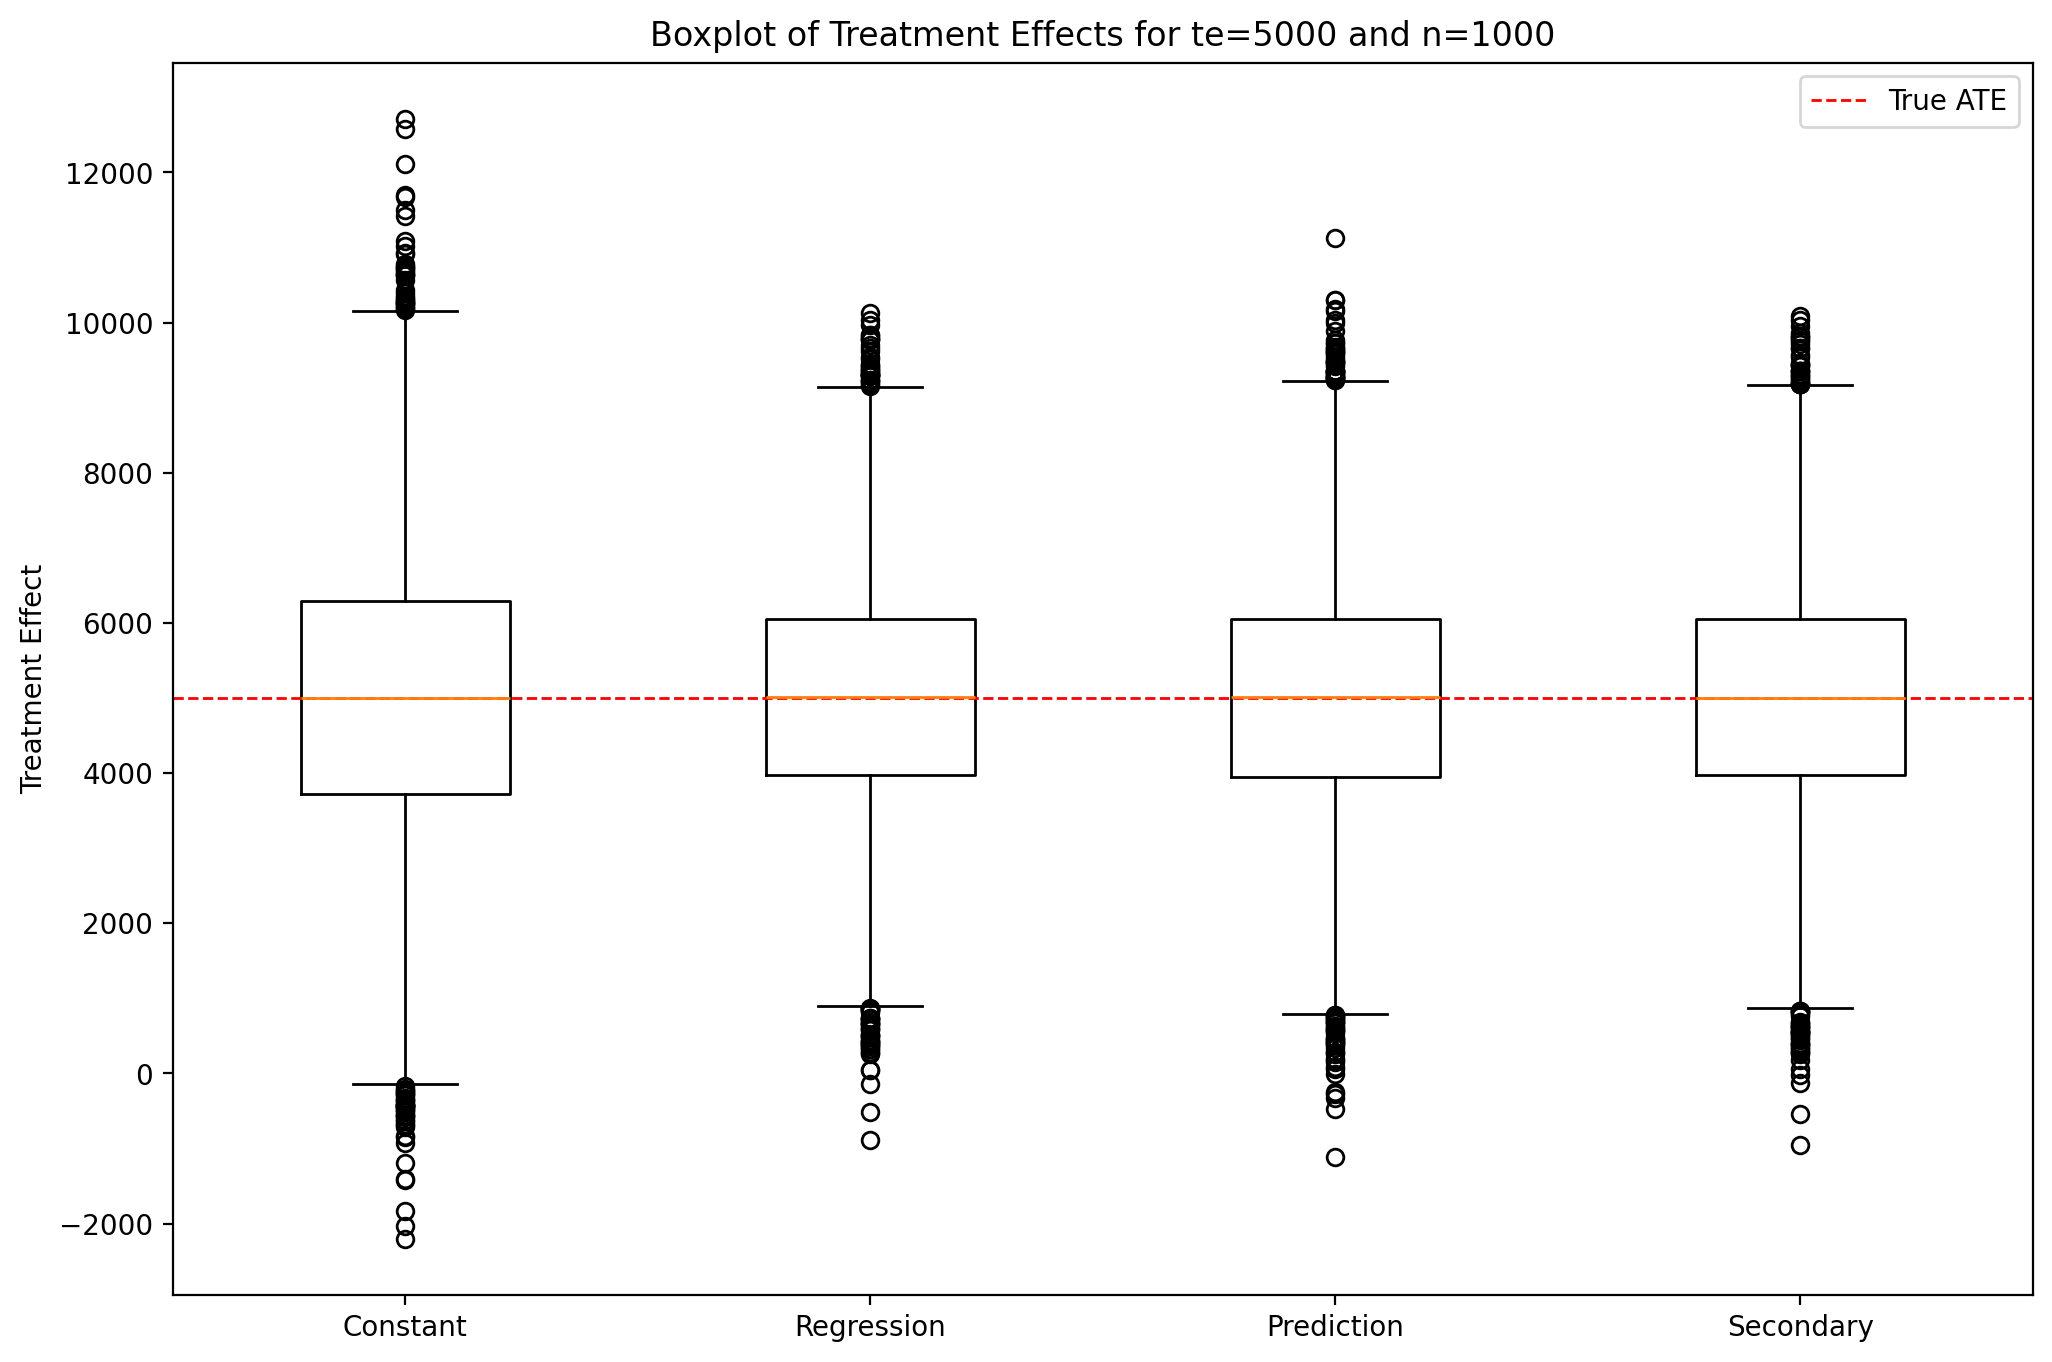

In [13]:
# Create boxplots for each combination of te and n
for te in te_lst:
    for n in n_lst:
        # Filter the results for the current combination of te and n
        subset = results.iloc[(idx - total):(idx - total + r)]
        
        # Create a new figure
        plt.figure(figsize=(12, 8), dpi=dpi)
        
        # Create boxplots for each method
        plt.boxplot([subset['Constant ATE'], subset['Regression ATE'], subset['Prediction ATE'], subset['Secondary ATE']],
                    labels=['Constant', 'Regression', 'Prediction', 'Secondary'])
        
        # Add a horizontal line for the true treatment effect
        plt.axhline(y=te, color='r', linestyle='--', linewidth=1, label='True ATE')
        
        # Add title and labels
        plt.title(f'Boxplot of Treatment Effects for te={te} and n={n}')
        plt.ylabel('Treatment Effect')
        plt.legend()
        
        # Show the plot
        plt.show()
        # Update the index for the next subset
        idx += r

In [15]:
# summarize the results dataframe
# first average the treatment effect estimate for each n and te and method combination
summary = results.groupby(['te', 'n']).mean().reset_index()
# also add a column for standard deviation of treatment effect estimates for each n and te and method combination
summary['Constant SD'] = results.groupby(['te', 'n'])['Constant ATE'].std().values
summary['Regression SD'] = results.groupby(['te', 'n'])['Regression ATE'].std().values
summary['Prediction SD'] = results.groupby(['te', 'n'])['Prediction ATE'].std().values
summary['Secondary SD'] = results.groupby(['te', 'n'])['Secondary ATE'].std().values
# add columns denoting bias of each method 
# if te is 0, set bias to be the absolute difference between the estimate and 0
# otherwise, set bias to be the relative difference between the estimate and te
summary['Constant Bias'] = np.where(summary['te'] == 0, np.abs(summary['Constant ATE']), np.abs((summary['Constant ATE'] - summary['te'])/summary['te']))
summary['Regression Bias'] = np.where(summary['te'] == 0, np.abs(summary['Regression ATE']), np.abs((summary['Regression ATE'] - summary['te'])/summary['te']))
summary['Prediction Bias'] = np.where(summary['te'] == 0, np.abs(summary['Prediction ATE']), np.abs((summary['Prediction ATE'] - summary['te'])/summary['te']))
summary['Secondary Bias'] = np.where(summary['te'] == 0, np.abs(summary['Secondary ATE']), np.abs((summary['Secondary ATE'] - summary['te'])/summary['te']))
print(summary)

      te     n  Constant ATE  Constant SE  Constant Rej  Regression ATE  \
0      0   100     -33.93360  6157.409995        0.0503       -9.014345   
1      0   200      26.01535  4364.339979        0.0469       -0.332242   
2      0   500       1.29834  2761.073249        0.0521        5.730649   
3      0  1000     -31.25713  1952.690273        0.0499      -29.694013   
4   1000   100     818.69790  6157.596261        0.0533      922.187997   
5   1000   200     968.56145  4361.456310        0.0600      962.815791   
6   1000   500     975.27530  2760.588039        0.0650      972.184535   
7   1000  1000     989.95340  1952.408464        0.0822      991.310302   
8   2000   100    1928.03780  6163.372007        0.0612     1976.221589   
9   2000   200    2053.44420  4364.474722        0.0766     1997.217200   
10  2000   500    1957.28700  2760.980550        0.1078     1980.021977   
11  2000  1000    2001.25332  1952.698504        0.1790     1995.516701   
12  5000   100    4922.10

In [17]:
# fix latex string with new te_lst
latex_table = r"""
\begin{table*}
\caption{Results for the Manufactured Housing (MH) dataset. Bias is given as the relative bias to the true treatment effect $\tau$, except when $\tau = 0$ where the average treatment effect estimate is given instead. Rejection proportion is the proportion of the 10,000 simulations in which $H_0$ was rejected at significance level $\alpha = 5\%$.}
\centering
\begin{tabular}[t]{llrrrrrrrr}
\toprule
\multicolumn{2}{c}{} & \multicolumn{4}{c}{Bias} & \multicolumn{4}{c}{Rejection Proportion of $H_0: \tau = 0$} \\
\cmidrule(l{3pt}r{3pt}){1-2}\cmidrule(l{3pt}r{3pt}){3-6} \cmidrule(l{3pt}r{3pt}){7-10}
 $n$ & $\tau$ & $\tau_c$ & $\tau_r$ & $\tau_p$ & $\tau_s$ & $\tau_c$ & $\tau_r$ & $\tau_p$ & $\tau_s$ \\
\midrule
\addlinespace[0.3em]
\multicolumn{10}{l}{}\\
100&0 & {100_0_tau_c} & {100_0_tau_r} & {100_0_tau_p} & {100_0_tau_s} & {100_0_rej_c} & {100_0_rej_r} & {100_0_rej_p} & {100_0_rej_s}\\
&1000 & {1000_1000_tau_c} & {1000_1000_tau_r} & {1000_1000_tau_p} & {1000_1000_tau_s} & {1000_1000_rej_c} & {1000_1000_rej_r} & {1000_1000_rej_p} & {1000_1000_rej_s}\\
&2000 & {100_2000_tau_c} & {100_2000_tau_r} & {100_2000_tau_p} & {100_2000_tau_s} & {100_2000_rej_c} & {100_2000_rej_r} & {100_2000_rej_p} & {100_2000_rej_s}\\
&5000 & {100_5000_tau_c} & {100_5000_tau_r} & {100_5000_tau_p} & {100_5000_tau_s} & {100_5000_rej_c} & {100_5000_rej_r} & {100_5000_rej_p} & {100_5000_rej_s}\\
\addlinespace[0.3em]
\multicolumn{10}{l}{}\\
200&0 & {200_0_tau_c} & {200_0_tau_r} & {200_0_tau_p} & {200_0_tau_s} & {200_0_rej_c} & {200_0_rej_r} & {200_0_rej_p} & {200_0_rej_s}\\
&1000 & {200_1000_tau_c} & {200_1000_tau_r} & {200_1000_tau_p} & {200_1000_tau_s} & {200_1000_rej_c} & {200_1000_rej_r} & {200_1000_rej_p} & {200_1000_rej_s}\\
&2000 & {200_2000_tau_c} & {200_2000_tau_r} & {200_2000_tau_p} & {200_2000_tau_s} & {200_2000_rej_c} & {200_2000_rej_r} & {200_2000_rej_p} & {200_2000_rej_s}\\
&5000 & {200_5000_tau_c} & {200_5000_tau_r} & {200_5000_tau_p} & {200_5000_tau_s} & {200_5000_rej_c} & {200_5000_rej_r} & {200_5000_rej_p} & {200_5000_rej_s}\\
\addlinespace[0.3em]
\multicolumn{10}{l}{}\\
500&0 & {500_0_tau_c} & {500_0_tau_r} & {500_0_tau_p} & {500_0_tau_s} & {500_0_rej_c} & {500_0_rej_r} & {500_0_rej_p} & {500_0_rej_s}\\
&1000 & {500_1000_tau_c} & {500_1000_tau_r} & {500_1000_tau_p} & {500_1000_tau_s} & {500_1000_rej_c} & {500_1000_rej_r} & {500_1000_rej_p} & {500_1000_rej_s}\\
&2000 & {500_2000_tau_c} & {500_2000_tau_r} & {500_2000_tau_p} & {500_2000_tau_s} & {500_2000_rej_c} & {500_2000_rej_r} & {500_2000_rej_p} & {500_2000_rej_s}\\
&5000 & {500_5000_tau_c} & {500_5000_tau_r} & {500_5000_tau_p} & {500_5000_tau_s} & {500_5000_rej_c} & {500_5000_rej_r} & {500_5000_rej_p} & {500_5000_rej_s}\\
\addlinespace[0.3em]
\multicolumn{10}{l}{}\\
1000&0 & {1000_0_tau_c} & {1000_0_tau_r} & {1000_0_tau_p} & {1000_0_tau_s} & {1000_0_rej_c} & {1000_0_rej_r} & {1000_0_rej_p} & {1000_0_rej_s}\\
&1000 & {1000_1000_tau_c} & {1000_1000_tau_r} & {1000_1000_tau_p} & {1000_1000_tau_s} & {1000_1000_rej_c} & {1000_1000_rej_r} & {1000_1000_rej_p} & {1000_1000_rej_s}\\
&3000 & {1000_2000_tau_c} & {1000_2000_tau_r} & {1000_2000_tau_p} & {1000_2000_tau_s} & {1000_2000_rej_c} & {1000_2000_rej_r} & {1000_2000_rej_p} & {1000_2000_rej_s}\\
&5000 & {1000_5000_tau_c} & {1000_5000_tau_r} & {1000_5000_tau_p} & {1000_5000_tau_s} & {1000_5000_rej_c} & {1000_5000_rej_r} & {1000_5000_rej_p} & {1000_5000_rej_s}\\
\bottomrule
\end{tabular}
\label{tab: MU summary}
\end{table*}
"""

for te in te_lst:
    factor = 1 if te == 0 else 100
    for n in n_lst:
        subset = summary[(summary['te'] == te) & (summary['n'] == n)]
        bias_constant = subset['Constant Bias'].values[0] * factor
        bias_regression = subset['Regression Bias'].values[0] * factor
        bias_prediction = subset['Prediction Bias'].values[0] * factor
        bias_secondary = subset['Secondary Bias'].values[0] * factor
        rej_constant = subset['Constant Rej'].values[0] * 100
        rej_regression = subset['Regression Rej'].values[0] * 100
        rej_prediction = subset['Prediction Rej'].values[0] * 100
        rej_secondary = subset['Secondary Rej'].values[0] * 100
        
        if te == 0:
            latex_table = latex_table.replace(f"{n}_{te}_tau_c", f"{bias_constant:.2f}")
            latex_table = latex_table.replace(f"{n}_{te}_tau_r", f"{bias_regression:.2f}")
            latex_table = latex_table.replace(f"{n}_{te}_tau_p", f"{bias_prediction:.2f}")
            latex_table = latex_table.replace(f"{n}_{te}_tau_s", f"{bias_secondary:.2f}")
        else:
            latex_table = latex_table.replace(f"{n}_{te}_tau_c", f"{bias_constant:.2f}\%")
            latex_table = latex_table.replace(f"{n}_{te}_tau_r", f"{bias_regression:.2f}\%")
            latex_table = latex_table.replace(f"{n}_{te}_tau_p", f"{bias_prediction:.2f}\%")
            latex_table = latex_table.replace(f"{n}_{te}_tau_s", f"{bias_secondary:.2f}\%")
        latex_table = latex_table.replace(f"{n}_{te}_rej_c", f"{rej_constant:.2f}\%")
        latex_table = latex_table.replace(f"{n}_{te}_rej_r", f"{rej_regression:.2f}\%")
        latex_table = latex_table.replace(f"{n}_{te}_rej_p", f"{rej_prediction:.2f}\%")
        latex_table = latex_table.replace(f"{n}_{te}_rej_s", f"{rej_secondary:.2f}\%")
        
print(latex_table)


\begin{table*}
\centering
\begin{tabular}[t]{llrrrrrrrr}
\toprule
\multicolumn{2}{c}{} & \multicolumn{4}{c}{Bias} & \multicolumn{4}{c}{Rejection Proportion of $H_0: \tau = 0$} \\
\cmidrule(l{3pt}r{3pt}){1-2}\cmidrule(l{3pt}r{3pt}){3-6} \cmidrule(l{3pt}r{3pt}){7-10}
 $n$ & $\tau$ & $\tau_c$ & $\tau_r$ & $\tau_p$ & $\tau_s$ & $\tau_c$ & $\tau_r$ & $\tau_p$ & $\tau_s$ \\
\midrule
\addlinespace[0.3em]
\multicolumn{10}{l}{}\\
\hspace{1em}100&0 & {33.93} & {9.01} & {11.02} & {4.52} & {5.03\%} & {5.25\%} & {4.98\%} & {5.17\%}\\
\hspace{1em}&1000 & {1.00\%} & {0.87\%} & {0.73\%} & {0.91\%} & {8.22\%} & {9.90\%} & {9.64\%} & {9.75\%}\\
\hspace{1em}&2000 & {3.60\%} & {1.19\%} & {2.21\%} & {1.41\%} & {6.12\%} & {7.31\%} & {6.56\%} & {7.33\%}\\
\hspace{1em}&5000 & {1.56\%} & {1.32\%} & {1.35\%} & {1.33\%} & {12.71\%} & {17.93\%} & {16.94\%} & {17.87\%}\\
\addlinespace[0.3em]
\multicolumn{10}{l}{}\\
\hspace{1em}200&0 & {26.02} & {0.33} & {11.84} & {1.92} & {4.69\%} & {5.19\%} & {4.95\%} & {5.25\%}